In [1]:
import os
from datetime import datetime
# Make logging folder named according to current time
start_time_str = datetime.today().strftime('%d_%m_%Y__%H_%M_%S')
log_dir = './logs/'f"log_{start_time_str}"
os.makedirs(log_dir)

# Initialize logger that adds to text file in current logging folder
from logging_utils import *


# Initialize logger that adds to text file in current logging folder
from logging_utils import *
init_logger(save_dir=log_dir)
logger = get_logger()

In [2]:
import pathlib
import subprocess
# Get the absolute path to your repository, 
# no matter where you are running this code from

repo_path = os.getcwd() 


git_branch = subprocess.check_output(
    ["git", "-C", repo_path, "rev-parse", "--abbrev-ref", "HEAD"]).strip().decode('UTF-8')

git_commit_short_hash = subprocess.check_output(
    ["git", "-C", repo_path, "describe", "--always"]).strip().decode('UTF-8')


In [3]:
from src_dir import *
import numpy as np

dim=30


x0=np.squeeze(np.zeros((dim,dim)))
x0Type='Zero Solution 2D'

# FD_StencilMat=np.zeros((dim,dim))
# b = np.ones(dim-1)
# c = -2*np.ones(dim)
# np.fill_diagonal(FD_StencilMat[1:], b)
# np.fill_diagonal(FD_StencilMat[:,1:], b)
# np.fill_diagonal(FD_StencilMat, c)
# A=FD_StencilMat
# A=np.asmatrix(A)

A=mk_laplace_2d(dim,dim)
AType='2D Laplacian'

retrain_freq=1
e1 = 1e-5
e2 = 1e-6
nmax_iter =int(dim/5)
restart   = 64

# sigma=0.02
sigma=0.2


DomainL=-1.0
DomainR=1.0

x1=np.linspace(DomainL,DomainR,dim)
x2=np.linspace(DomainL,DomainR,dim)
X, Y = np.meshgrid(x1, x2, sparse=False, indexing='ij')

n_steps =5000
InputDim=dim
HiddenDim=dim
OutputDim=dim

In [4]:
# check 2d grid and RHS

import matplotlib.pyplot as pp
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = pp.figure()
ax = fig.add_subplot(111, projection='3d')
ProbIdx=30

# Z=np.sin(1)*X+np.cos(1)*Y

# xloc=np.cos(6*ProbIdx)*np.cos(ProbIdx)
# yloc=np.cos(6*ProbIdx)*np.sin(ProbIdx)
xloc=np.random.uniform(-1,1)
yloc=np.random.uniform(-1,1)
Z=Gauss_pdf_2D(X,Y,xloc,yloc,sigma)

# Z=np.maximum(2*X*np.sin(ProbIdx),2*Y*np.cos(ProbIdx))

ax.plot_surface(X,Y,Z,cmap=cm.coolwarm)

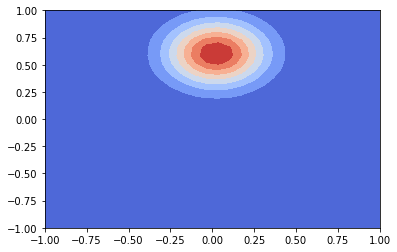

In [5]:
pp.contourf(X,Y,Z,cmap=cm.coolwarm)

In [6]:
# Initial log message
logger.info("Single layer NN of (dim,dim) size. No nonlinear activation. Dim 30.")
#  The source is a narrow gaussian that depends on the integer 'time' in a nonlinear way. The gaussian is on the interval [-5,5], and constrained to move on [-3,3]. ")



# Set up parameter class
class MyParamsClass():
    def __init__(self, AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash):
        self.AType = AType
        self.dim = dim
        self.nmax_iter = nmax_iter
        self.restart = restart
        self.n_steps =n_steps
        self.retrain_freq=retrain_freq
        self.e1=e1
        self.e2=e2
        self.x0Type=x0Type
        self.InputDim=InputDim
        self.HiddenDim=HiddenDim
        self.OutputDim=OutputDim
        self.sigma=sigma
        self.DomainL=DomainL
        self.DomainR=DomainR
        self.git_branch=git_branch
        self.git_commit_short_hash=git_commit_short_hash





import os
import json

params = MyParamsClass(AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash)
sorted_params_dict = {k: params.__dict__[k] for k 
                      in sorted(params.__dict__.keys())}

params_filepath = log_dir+'/params.json'
json.dump(sorted_params_dict, open(params_filepath, 'w'), indent=4)

2020-08-07 01:00:41 [INFO] <ipython-input-6-3dbfefd04fd5> 2 - Single layer NN of (dim,dim) size. No nonlinear activation. Dim 30.


In [7]:
from src_dir import *

# @nn_preconditioner(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,HiddenDim2=HiddenDim2,OutputDim=OutputDim)
# def MLGMRES(A, b, x0, e, nmax_iter,IterErr0_sum,IterErr0,ProbCount,Add,restart,debug):
#     return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
@cnn_preconditionerOnline_timed_2D(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,OutputDim=OutputDim)
def MLGMRES(A, b ,x0, e, nmax_iter,ML_GMRES_Time_list,ProbCount,restart,debug,refine,blist,reslist,Err_list,reslist_flat,ML_GMRES_Time_list2,solIndx):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
def GMRES_timed(A, b, x0, e, nmax_iter,restart,debug):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)

In [8]:
from src_dir import *



ML_GMRES_Time_list=[]
ML_GMRES_Time_list2=[]

Err_list=[]
NonML_Err_List=[]

run_time_ML_list=[]
run_timeP1_ML_list=[]
run_timeP2_ML_list=[]

run_time_list=[]
GmresRunTimeOriginal=[]
GmresRunTimeOriginal2=[]

trainTime_list=[]


debug=True
refine1=False
refine2=True

blist=[]
reslist=[]
reslist_flat=[]

solIndx=0

for ProbIdx in range(n_steps):


#     xloc=np.cos(6*ProbIdx)*np.cos(ProbIdx)
#     yloc=np.cos(6*ProbIdx)*np.sin(ProbIdx)
#     np.random.seed(0)
    xloc=np.random.uniform(-1,1)
    yloc=np.random.uniform(-1,1)
    b=Gauss_pdf_2D(X,Y,xloc,yloc,sigma)


#     b=np.maximum(2*X*np.sin(ProbIdx),2*Y*np.cos(ProbIdx))

    b_flat=np.reshape(b,(1,-1),order='F').squeeze(0)
    b_norm=np.linalg.norm(b_flat)


    OutList1,run_time1_ML=MLGMRES(A, b/b_norm, x0, e1, nmax_iter,ML_GMRES_Time_list,ProbIdx,restart,debug,refine1,blist,reslist,Err_list,reslist_flat,ML_GMRES_Time_list2,solIndx)  # normalize b for optimal NN performance.
    Out=OutList1[0]
    ML_GMRES_Time_list=OutList1[1]
    blist=OutList1[3]
    reslist=OutList1[4]
    Err_list=OutList1[5]
    reslist_flat=OutList1[6]

    OutList2,run_time2_ML=MLGMRES(A, b/b_norm,Out[-1], e2, nmax_iter,ML_GMRES_Time_list,ProbIdx,restart,debug,refine2,blist,reslist,Err_list,reslist_flat,ML_GMRES_Time_list2,solIndx)
    Out2=OutList2[0]
    ML_GMRES_Time_list=OutList2[1]
    trainTime_list.append(OutList2[2])
    blist=OutList2[3]
    reslist=OutList2[4]
    Err_list=OutList2[5]
    reslist_flat=OutList2[6]
    ML_GMRES_Time_list2=OutList2[7]
    solIndx=OutList2[8]

    run_timeP1_ML_list.append(run_time1_ML)
    run_timeP2_ML_list.append(run_time2_ML)
    run_time_ML_list.append(run_time1_ML+run_time2_ML)
    



    NonML_Out1,run_time1=GMRES_timed(A, b/b_norm, x0, e1, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    NonML_Err=resid(A, NonML_Out1, b/b_norm)
    NonML_Err_List.append(NonML_Err[5])
   
    NonML_Out2,run_time2=GMRES_timed(A, b/b_norm, NonML_Out1[-1], e2, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    
    GmresRunTimeOriginal.append(run_time1)
    GmresRunTimeOriginal2.append(run_time2)
    run_time_list.append(run_time1+run_time2)
    
    MLGMRES_GMRES_ONLY=sum(ML_GMRES_Time_list2)+sum(ML_GMRES_Time_list)

    print(ProbIdx)

run_time=sum(run_time_list)
run_time_ML=sum(run_time_ML_list)
trainTime_total=sum(trainTime_list)


logger.info("Runtime of Non-decorated version is:")
logger.info(run_time)

logger.info("Runtime of MLGMRES decorator is:")
logger.info(run_time_ML)

logger.info("Runtime of MLGMRES (only GMRES time) is:")
logger.info(MLGMRES_GMRES_ONLY)


logger.info("Runtime of training (backprop) is:")
logger.info(trainTime_total)



0
1
Final loss: 9.776717888598796e-06
parameters 810394
Initial Training
2
size 8
0.7294151431849595 0.5575910607411738
poor prediction,using initial x0
2.297471015001065 2.1379111130008823 0.7294151431849595 0.5469939026319557
2.297471015001065 2.1379111130008823 0.7294151431849595 0.5469939026319557
3
size 8
0.5212520388208326 0.7294151431849595
2.196350583995809 2.139787094500207 1.1998148813821081 0.6329059438538486
2.196350583995809 2.139787094500207 1.1998148813821081 0.6329059438538486
4
size 8
0.5844079329303827 1.1998148813821081
1.5850907900021411 2.158641590998741 1.1283325022953676 0.8218755896966018
1.5850907900021411 2.158641590998741 1.1283325022953676 0.8218755896966018
5
size 8
0.5415738454511672 1.1998148813821081
1.5755757430015365 2.026304129666338 0.4031794194932309 1.0191875089541451
1.5755757430015365 2.026304129666338 0.4031794194932309 1.0191875089541451
6
size 8
0.516434618288397 1.1998148813821081
2.148934207012644 1.913622033000138 0.47681507785814253 0.8651

40
size 8
0.5395101091199426 1.7380041453812294
1.9608797860128107 1.5367964610800846 0.7133797788304762 0.9347879825023352
1.9608797860128107 1.5367964610800846 0.7133797788304762 0.9347879825023352
41
size 8
0.5359916426557744 1.7380041453812294
1.6659292800031835 1.5350966584001435 0.5489524378690779 0.9066603757704429
1.6659292800031835 1.5350966584001435 0.5489524378690779 0.9066603757704429
42
size 8
0.5604601275956912 1.7380041453812294
1.6924558710015845 1.5361008079198655 1.4492083254631452 0.859098307469957
1.6924558710015845 1.5361008079198655 1.4492083254631452 0.859098307469957
43
size 8
0.5238555820685621 1.7380041453812294
1.8257265319989529 1.5267296771198744 0.8076885974411827 0.877833162153849
1.8257265319989529 1.5267296771198744 0.8076885974411827 0.877833162153849
44
size 8
0.5316758686447906 1.7380041453812294
2.0353974040044704 1.5292263549997005 1.0801126938550556 0.8624975889783731
2.0353974040044704 1.5292263549997005 1.0801126938550556 0.8624975889783731
Inne

Final loss: 7.444087532348931e-05
parameters 810394
79
size 8
0.5131773012873002 1.7380041453812294
2.2507959899958223 1.5523678780376213 1.1296718483973307 0.6845556826244281
2.2507959899958223 1.5523678780376213 1.1296718483973307 0.6845556826244281
80
size 8
0.5041664304864842 1.7380041453812294
2.0643697359919315 1.5939845075173071 1.1584701650749374 0.7213900555214591
2.0643697359919315 1.5939845075173071 1.1584701650749374 0.7213900555214591
81
size 8
0.42523681362338356 1.7380041453812294
1.7831322569982149 1.6117956323572435 0.5344575520984591 0.7445602885995127
1.7831322569982149 1.6117956323572435 0.5344575520984591 0.7445602885995127
82
size 8
0.7516720133449744 1.7380041453812294
1.724293587001739 1.6166829534375575 0.8979961253628559 0.7488726851251789
1.724293587001739 1.6166829534375575 0.8979961253628559 0.7488726851251789
InnerProd [[1.         0.37913055 0.33553471]
 [0.37913055 1.         0.60054467]
 [0.33553471 0.60054467 1.        ]]
retraining
3
Final loss: 9.773

118
size 8
0.4742773681119918 1.7380041453812294
1.4743089599942323 1.2876373189594597 0.7372991762273766 0.3685491911080363
1.4743089599942323 1.2876373189594597 0.7372991762273766 0.3685491911080363
119
size 8
0.41358549234878633 1.7380041453812294
1.494422678995761 1.2830546658788808 0.060907457646837394 0.37922151974060603
1.494422678995761 1.2830546658788808 0.060907457646837394 0.37922151974060603
120
size 8
0.5105052180858343 1.7380041453812294
1.4779752399917925 1.261223069758853 0.4740708381192196 0.3552173959821168
1.4779752399917925 1.261223069758853 0.4740708381192196 0.3552173959821168
121
size 8
0.5634307841756949 1.7380041453812294
1.426703152988921 1.284817923278315 0.9985019612582551 0.3705118167812963
1.426703152988921 1.284817923278315 0.9985019612582551 0.3705118167812963
InnerProd [[1.         0.69467123 0.88692398]
 [0.69467123 1.         0.85361816]
 [0.88692398 0.85361816 1.        ]]
retraining
2
Final loss: 0.0015656485920771956
parameters 810394
122
size 8
0.

1.5289556320058182 1.3385738578403834 0.25153760611216724 0.3271430841831557
1.5289556320058182 1.3385738578403834 0.25153760611216724 0.3271430841831557
155
size 8
0.49645163399884473 1.7380041453812294
1.7279209440021077 1.3537686182407196 0.41430496051871346 0.3299548615116574
1.7279209440021077 1.3537686182407196 0.41430496051871346 0.3299548615116574
156
size 8
0.5499846121545224 1.7380041453812294
1.4004438089905307 1.3600135296810185 0.3519240294645946 0.3207020747114834
1.4004438089905307 1.3600135296810185 0.3519240294645946 0.3207020747114834
157
size 8
0.4374319161140312 1.7380041453812294
1.1981357219920028 1.3424126942403383 0.2619754442715018 0.31794710431530027
1.1981357219920028 1.3424126942403383 0.2619754442715018 0.31794710431530027
158
size 8
0.49615960878946636 1.7380041453812294
1.2367463349946775 1.3075222095998469 0.11401462697135578 0.2994281144382015
1.2367463349946775 1.3075222095998469 0.11401462697135578 0.2994281144382015
159
size 8
0.544008166611913 1.738

192
size 8
0.5318392122277117 1.7380041453812294
1.209173497001757 1.2573398528416875 0.09194592590165923 0.1716839822088814
1.209173497001757 1.2573398528416875 0.09194592590165923 0.1716839822088814
193
size 8
0.6163472385819605 1.7380041453812294
1.0191440089984098 1.2364167360018472 0.06745921029240781 0.16198089950621308
1.0191440089984098 1.2364167360018472 0.06745921029240781 0.16198089950621308
194
size 8
0.4874759106350159 1.7380041453812294
1.3923422780062538 1.2420478702016409 0.14762910201934878 0.1607658346028673
1.3923422780062538 1.2420478702016409 0.14762910201934878 0.1607658346028673
195
size 8
0.5323541472679199 1.7380041453812294
1.1718249690020457 1.2486143585218814 0.12389680715474961 0.15991794000920487
1.1718249690020457 1.2486143585218814 0.12389680715474961 0.15991794000920487
196
size 8
0.6255708152631023 1.7380041453812294
1.1599283459945582 1.2515058987616794 0.09556787158770261 0.1594716496543715
1.1599283459945582 1.2515058987616794 0.09556787158770261 0.

1.178217851993395 1.0650248136383016 0.18026294180791289 0.11957841195040625
231
size 8
0.5455515092175299 1.7380041453812294
1.4348066300008213 1.0782958826381945 0.16006286448375492 0.1253268603187937
1.4348066300008213 1.0782958826381945 0.16006286448375492 0.1253268603187937
InnerProd [[1.         0.8846307  0.55663632]
 [0.8846307  1.         0.49883946]
 [0.55663632 0.49883946 1.        ]]
retraining
3
Final loss: 0.35535770654678345
parameters 810394
232
size 8
0.5556530355882374 1.7380041453812294
1.76462937600445 1.0808146948780633 0.24850396011703563 0.12872760306329362
1.76462937600445 1.0808146948780633 0.24850396011703563 0.12872760306329362
233
size 8
0.48367718271139515 1.7380041453812294
1.2005415669991635 1.107534890078241 0.043625743542261654 0.13159382051797577
1.2005415669991635 1.107534890078241 0.043625743542261654 0.13159382051797577
234
size 8
0.5514107127586183 1.7380041453812294
0.991014241008088 1.1172651242779101 0.1381631404107711 0.12776125840251773
0.9910

0.9068388080049772 1.0569052650796948 0.04227501116993802 0.08311459726019643
269
size 8
0.5244836713735244 1.7380041453812294
0.9166844499995932 1.023130915799993 0.07081636243300393 0.078655116096318
0.9166844499995932 1.023130915799993 0.07081636243300393 0.078655116096318
270
size 8
0.5514614168589732 1.7380041453812294
1.4567634660052136 1.0172332726803142 0.07071199811791196 0.07853099143773394
1.4567634660052136 1.0172332726803142 0.07071199811791196 0.07853099143773394
271
size 8
0.5657534982067738 1.7380041453812294
1.0031744849984534 1.030168438560213 0.10192525049386966 0.07761615264505205
1.0031744849984534 1.030168438560213 0.10192525049386966 0.07761615264505205
272
size 8
0.5514108086531294 1.7380041453812294
1.4381845300085843 1.0287408244400285 0.06224400368560598 0.07798616816084732
1.4381845300085843 1.0287408244400285 0.06224400368560598 0.07798616816084732
273
size 8
0.5384644561514117 1.7380041453812294
0.8782243979949271 1.0425179493206087 0.050970069668336816 0.

0.5227004339976702 1.026845774759422 0.03425776003532851 0.08834776343515792
0.5227004339976702 1.026845774759422 0.03425776003532851 0.08834776343515792
308
size 8
0.5100657012078356 1.7380041453812294
0.8798238079907605 1.007111984679359 0.019903664818933763 0.0841140215203121
0.8798238079907605 1.007111984679359 0.019903664818933763 0.0841140215203121
309
size 8
0.7799528948534523 1.7380041453812294
0.8965762450097827 0.9900458117993548 0.03906617531515792 0.07059378921548022
0.8965762450097827 0.9900458117993548 0.03906617531515792 0.07059378921548022
310
size 8
0.5261617466803622 1.7380041453812294
0.7384073190041818 0.9729972885997268 0.0990914568653435 0.0690835103477387
0.7384073190041818 0.9729972885997268 0.0990914568653435 0.0690835103477387
311
size 8
0.4730183954321443 1.7380041453812294
0.8369461649999721 0.9628976239595795 0.01258300061609487 0.07073241173712143
0.8369461649999721 0.9628976239595795 0.01258300061609487 0.07073241173712143
312
size 8
0.6333386423212157 1.

345
size 8
0.45603661679405244 1.7380041453812294
0.853259600000456 0.9159853133984143 0.03415305894189475 0.033402576649751825
0.853259600000456 0.9159853133984143 0.03415305894189475 0.033402576649751825
346
size 8
0.5367162937542048 1.7380041453812294
1.3547049749904545 0.9041096199984895 0.04233437692969655 0.03223626900238727
1.3547049749904545 0.9041096199984895 0.04233437692969655 0.03223626900238727
347
size 8
0.5144225191165496 1.7380041453812294
0.8852793980040587 0.9242758852383122 0.03334440108350568 0.032226365950316346
0.8852793980040587 0.9242758852383122 0.03334440108350568 0.032226365950316346
348
size 8
0.4811885743219636 1.7380041453812294
1.3240872379974462 0.9075681891583371 0.026985283956869745 0.0324713923754526
1.3240872379974462 0.9075681891583371 0.026985283956869745 0.0324713923754526
349
size 8
0.4986151103625123 1.7380041453812294
0.7510645400034264 0.9062849127984373 0.04299858004753887 0.030240418064789276
0.7510645400034264 0.9062849127984373 0.042998580

1.1756549309939146 0.9856050726794637 0.02180534077181086 0.034584614878835615
382
size 8
0.6414047353916703 1.7380041453812294
0.9196673980040941 0.9948896288796095 0.03811983790553109 0.03420808558570328
0.9196673980040941 0.9948896288796095 0.03811983790553109 0.03420808558570328
383
size 8
0.7283828036769032 1.7380041453812294
0.6397249330038903 0.9887543354794616 0.009743543714689254 0.03459542016727702
0.6397249330038903 0.9887543354794616 0.009743543714689254 0.03459542016727702
384
size 8
0.516432906858902 1.7380041453812294
1.106455619999906 0.970326491399901 0.04831494318876396 0.032613342467949266
1.106455619999906 0.970326491399901 0.04831494318876396 0.032613342467949266
InnerProd [[1.         0.34924879 0.33834028]
 [0.34924879 1.         0.53980762]
 [0.33834028 0.53980762 1.        ]]
retraining
3
Final loss: 0.16274675726890564
parameters 810394
385
size 8
0.6194935506263232 1.7380041453812294
1.0878715450089658 0.9800942612800282 0.019146745224231522 0.033956989930728

Final loss: 0.07891052216291428
parameters 810394
418
size 8
0.5601762396863225 1.7380041453812294
0.6425119540072046 0.8503818120795767 0.007999120679241113 0.027082796191551788
0.6425119540072046 0.8503818120795767 0.007999120679241113 0.027082796191551788
419
size 8
0.5190946514186092 1.7380041453812294
0.7169989849935519 0.8391570740402676 0.01523914766032715 0.026836962933563697
0.7169989849935519 0.8391570740402676 0.01523914766032715 0.026836962933563697
420
size 8
0.5370833741284915 1.7380041453812294
0.6800407479895512 0.8269555306399706 0.00860690615009807 0.02599221235836517
0.6800407479895512 0.8269555306399706 0.00860690615009807 0.02599221235836517
421
size 8
0.5114026656531423 1.7380041453812294
0.7860141690034652 0.8185779465996893 0.02497550291606773 0.024955819496879986
0.7860141690034652 0.8185779465996893 0.02497550291606773 0.024955819496879986
422
size 8
0.7817806083097605 1.7380041453812294
0.9731845019996399 0.8104061417200137 0.01896410114176877 0.0243786515381

0.5490171090059448 0.7440782019589096 0.021057675652163793 0.016583453372446544
456
size 8
0.5513899737523892 1.7380041453812294
0.6211995640042005 0.747553747119382 0.017993749645184128 0.01684037677577031
0.6211995640042005 0.747553747119382 0.017993749645184128 0.01684037677577031
457
size 8
0.5640409117583113 1.7380041453812294
0.8898708509950666 0.7348908173595555 0.039707845415184136 0.0166287058516291
0.8898708509950666 0.7348908173595555 0.039707845415184136 0.0166287058516291
InnerProd [[1.         0.57736719 0.58116983]
 [0.57736719 1.         0.46026421]
 [0.58116983 0.46026421 1.        ]]
retraining
3
Final loss: 0.08022361248731613
parameters 810394
458
size 8
0.5514452991285681 1.7380041453812294
1.0239886540075531 0.7389927077991888 0.010463509995315146 0.017298725073789788
1.0239886540075531 0.7389927077991888 0.010463509995315146 0.017298725073789788
459
size 8
0.42477272669702554 1.7380041453812294
0.48390560199914034 0.7471150143997511 0.01011396423464096 0.01727682

0.76614719099598 0.7109515416395152 0.0174793047528191 0.015084124093160758
493
size 8
0.5228676404470889 1.7380041453812294
0.7486031270091189 0.709856918399455 0.01032337760473442 0.015290357748982518
0.7486031270091189 0.709856918399455 0.01032337760473442 0.015290357748982518
494
size 8
0.6228777316384718 1.7380041453812294
0.747444345994154 0.6994557722395984 0.01210344090699851 0.014675050173627205
0.747444345994154 0.6994557722395984 0.01210344090699851 0.014675050173627205
495
size 8
0.6223690845403796 1.7380041453812294
0.9963643029914238 0.6963633553596447 0.021671201923687305 0.014053231600635561
0.9963643029914238 0.6963633553596447 0.021671201923687305 0.014053231600635561
InnerProd [[1.         0.94763419 0.68826   ]
 [0.94763419 1.         0.79807902]
 [0.68826    0.79807902 1.        ]]
retraining
3
Final loss: 0.0740688145160675
parameters 810394
496
size 8
0.42660054219224997 1.7380041453812294
0.6387516980030341 0.7206429583195131 0.018148098099074795 0.0141131749718

0.3908896380016813 0.6221188167604851 0.008734955612447571 0.011149568477139916
530
size 8
0.5757803369241606 1.7380041453812294
0.6855445770052029 0.6077271508408012 0.026221211238207198 0.011210357489238902
0.6855445770052029 0.6077271508408012 0.026221211238207198 0.011210357489238902
531
size 8
0.551325609224666 1.7380041453812294
0.5610232119943248 0.6194838842010358 0.013424506434293092 0.012020082969129021
0.5610232119943248 0.6194838842010358 0.013424506434293092 0.012020082969129021
532
size 8
0.4413840051179097 1.7380041453812294
0.6195808540069265 0.6287970056408085 0.01177087549571122 0.012321694184657107
0.6195808540069265 0.6287970056408085 0.01177087549571122 0.012321694184657107
533
size 8
0.5437230987067331 1.7380041453812294
0.616544721997343 0.6188630438811379 0.005503298559571643 0.012292129107084843
0.616544721997343 0.6188630438811379 0.005503298559571643 0.012292129107084843
534
size 8
0.5023157632550626 1.7380041453812294
0.6567114389908966 0.6221594226011075 0.

0.3922084859950701 0.6271546372416197 0.006700483566965835 0.01170023328319369
0.3922084859950701 0.6271546372416197 0.006700483566965835 0.01170023328319369
568
size 8
0.6559756195397284 1.7380041453812294
0.3588318299880484 0.621933103481424 0.005075255174457577 0.011694147284527218
0.3588318299880484 0.621933103481424 0.005075255174457577 0.011694147284527218
569
size 8
0.5438680905704952 1.7380041453812294
0.5924712499981979 0.6072073098813416 0.011533107156267543 0.01145611225909256
0.5924712499981979 0.6072073098813416 0.011533107156267543 0.01145611225909256
570
size 8
0.4381902969376721 1.7380041453812294
0.6056791680020979 0.6019030910811852 0.00806053547364856 0.01151500992024361
0.6056791680020979 0.6019030910811852 0.00806053547364856 0.01151500992024361
571
size 8
0.672113412080938 1.7380041453812294
0.7728713459946448 0.5991547509614611 0.010586383490216041 0.011528094103844706
0.7728713459946448 0.5991547509614611 0.010586383490216041 0.011528094103844706
572
size 8
0.45

605
size 8
0.5634419602339152 1.7380041453812294
0.7168536969984416 0.5520801702793687 0.01334801061967362 0.011321041755612098
0.7168536969984416 0.5520801702793687 0.01334801061967362 0.011321041755612098
InnerProd [[1.         0.72033354 0.92752802]
 [0.72033354 1.         0.56424795]
 [0.92752802 0.56424795 1.        ]]
retraining
2
Final loss: 0.03744420409202576
parameters 810394
606
size 8
0.47867674285850126 1.7380041453812294
0.6637228720064741 0.5662182325997855 0.006636777519903625 0.011534830749774514
0.6637228720064741 0.5662182325997855 0.006636777519903625 0.011534830749774514
607
size 8
0.5524738030504247 1.7380041453812294
0.6414302189950831 0.5680745224800193 0.0035723101432029985 0.01148601880808836
0.6414302189950831 0.5680745224800193 0.0035723101432029985 0.01148601880808836
608
size 8
0.42184444194245235 1.7380041453812294
0.49471028699190356 0.5702486265200423 0.0066814164063060556 0.011013684035897649
0.49471028699190356 0.5702486265200423 0.0066814164063060556

642
size 8
0.46516482361504286 1.7380041453812294
0.38533829599327873 0.5566775037586922 0.009474219882478917 0.010640424030940163
0.38533829599327873 0.5566775037586922 0.009474219882478917 0.010640424030940163
643
size 8
0.564474766160175 1.7380041453812294
0.5151391190011054 0.5491128537186887 0.011172920743703999 0.010658856649378767
0.5151391190011054 0.5491128537186887 0.011172920743703999 0.010658856649378767
644
size 8
0.5248220268245973 1.7380041453812294
0.6485085530002834 0.5433806643990101 0.01148118540272769 0.010563958020455016
0.6485085530002834 0.5433806643990101 0.01148118540272769 0.010563958020455016
645
size 8
0.5061984931848159 1.7380041453812294
0.5131215029978193 0.5491245668788907 0.00745205902913924 0.01071094159229216
0.5131215029978193 0.5491245668788907 0.00745205902913924 0.01071094159229216
646
size 8
0.516447605081988 1.7380041453812294
0.9203629289986566 0.5494745811587199 0.010374028214224373 0.010825049064895502
0.9203629289986566 0.5494745811587199 0.

0.367172254002071 0.5481364583998221 0.009615717361598823 0.009641141925381614
680
size 8
0.5466353837046722 1.7380041453812294
0.3681023339886451 0.5461038022401045 0.00809060933724165 0.009699359740254222
0.3681023339886451 0.5461038022401045 0.00809060933724165 0.009699359740254222
681
size 8
0.5635805107123987 1.7380041453812294
0.43109799599915277 0.536461490119691 0.00836291481585837 0.00964968185952356
0.43109799599915277 0.536461490119691 0.00836291481585837 0.00964968185952356
682
size 8
0.42748077537229817 1.7380041453812294
0.4982889509992674 0.5332653203193332 0.015008565934814325 0.009638192633184993
0.4982889509992674 0.5332653203193332 0.015008565934814325 0.009638192633184993
683
size 8
0.5625218625352464 1.7380041453812294
0.7069387450028444 0.5364161743992009 0.012086685623454524 0.009857653014827878
0.7069387450028444 0.5364161743992009 0.012086685623454524 0.009857653014827878
InnerProd [[1.         0.43047963 0.68643383]
 [0.43047963 1.         0.8117036 ]
 [0.6864

0.5732713780016638 0.5307603168778587 0.007206251101457038 0.008497806083649986
717
size 8
0.5573691155017974 1.7380041453812294
0.46912783599691465 0.5363571429578587 0.0059758953312707115 0.008477901276801217
0.46912783599691465 0.5363571429578587 0.0059758953312707115 0.008477901276801217
718
size 8
0.5658359716902518 1.7380041453812294
0.4522901610034751 0.5286969973979285 0.0058014018153908385 0.0082057628313351
0.4522901610034751 0.5286969973979285 0.0058014018153908385 0.0082057628313351
719
size 8
0.560481592659492 1.7380041453812294
0.3832207870000275 0.5238429674383951 0.010303246438867923 0.008041574586241542
0.3832207870000275 0.5238429674383951 0.010303246438867923 0.008041574586241542
720
size 8
0.5619596145286301 1.7380041453812294
0.3617586059990572 0.5245447302388493 0.008954183418988605 0.008156697571637818
0.3617586059990572 0.5245447302388493 0.008954183418988605 0.008156697571637818
721
size 8
0.6250860618904107 1.7380041453812294
0.6773320710053667 0.5218521863990

0.6398412769922288 0.588065563760465 0.006633542517504399 0.008662699277146297
754
size 8
0.5630909368511905 1.7380041453812294
0.5746288770023966 0.5728980097197928 0.009675345640353307 0.00845597446411352
0.5746288770023966 0.5728980097197928 0.009675345640353307 0.00845597446411352
755
size 8
0.5578339891703809 1.7380041453812294
0.4302751750074094 0.5701481737598079 0.005325630277751357 0.008505922743284938
0.4302751750074094 0.5701481737598079 0.005325630277751357 0.008505922743284938
756
size 8
0.5634807353413445 1.7380041453812294
0.6387287029938307 0.5589128018403425 0.006807311254522699 0.008143530110142143
0.6387287029938307 0.5589128018403425 0.006807311254522699 0.008143530110142143
757
size 8
0.6973941708397752 1.7380041453812294
0.6036859140003799 0.5581299542798661 0.005641793184342088 0.008038002557467233
0.6036859140003799 0.5581299542798661 0.005641793184342088 0.008038002557467233
758
size 8
0.5177478350651885 1.7380041453812294
0.823044769000262 0.5616816747601843 0

0.5530337439995492 0.5075263651605928 0.007892649350795288 0.006892787277230968
0.5530337439995492 0.5075263651605928 0.007892649350795288 0.006892787277230968
InnerProd [[1.         0.25331082 0.33122421]
 [0.25331082 1.         0.44214812]
 [0.33122421 0.44214812 1.        ]]
retraining
3
Final loss: 0.023005735129117966
parameters 810394
792
size 8
0.5166245731143012 1.7380041453812294
0.6386884469975485 0.5138012391206576 0.0058357136788368645 0.006991335890523994
0.6386884469975485 0.5138012391206576 0.0058357136788368645 0.006991335890523994
793
size 8
0.5525982028536809 1.7380041453812294
0.4979458760062698 0.5179809494008077 0.004234164066357614 0.006958979302482039
0.4979458760062698 0.5179809494008077 0.004234164066357614 0.006958979302482039
794
size 8
0.5524801493182345 1.7380041453812294
0.39260610500059556 0.51156512204092 0.008178246852440344 0.006726632565135573
0.39260610500059556 0.51156512204092 0.008178246852440344 0.006726632565135573
795
size 8
0.5587828691838771 

828
size 8
0.47934410603504146 1.7380041453812294
0.36077217999263667 0.5040266019210685 0.007842986237179083 0.007122144333431558
0.36077217999263667 0.5040266019210685 0.007842986237179083 0.007122144333431558
829
size 8
0.5451643742842553 1.7380041453812294
0.820816688996274 0.4860509410407394 0.006313083519588544 0.00702563325441299
0.820816688996274 0.4860509410407394 0.006313083519588544 0.00702563325441299
830
size 8
0.5530496892461504 1.7380041453812294
0.6067001379997237 0.4975847437203629 0.011724231217926569 0.0070060629634648534
0.6067001379997237 0.4975847437203629 0.011724231217926569 0.0070060629634648534
InnerProd [[1.         0.33271393 0.63362333]
 [0.33271393 1.         0.71528675]
 [0.63362333 0.71528675 1.        ]]
retraining
3
Final loss: 0.019570017233490944
parameters 810394
831
size 8
0.5523933995819094 1.7380041453812294
0.6811960869963514 0.5003966182802105 0.007103935628814838 0.007217151546001829
0.6811960869963514 0.5003966182802105 0.007103935628814838 0

0.4318926349951653 0.5582795096404152 0.0033738312716560673 0.006582993972376604
865
size 8
0.553891144497476 1.7380041453812294
0.42647753401251975 0.540748042560299 0.004721521475705071 0.006472108232450251
0.42647753401251975 0.540748042560299 0.004721521475705071 0.006472108232450251
866
size 8
0.5191246705535206 1.7380041453812294
0.32250265500624664 0.5347509711206658 0.004185027058677389 0.006447690555187417
0.32250265500624664 0.5347509711206658 0.004185027058677389 0.006447690555187417
867
size 8
0.5590041529519897 1.7380041453812294
0.46460664199548773 0.5175414896407164 0.004461016009455418 0.006268301392135894
0.46460664199548773 0.5175414896407164 0.004461016009455418 0.006268301392135894
868
size 8
0.5022935124891674 1.7380041453812294
0.2540197420021286 0.5119492672407069 0.003167743612892166 0.006218892674973421
0.2540197420021286 0.5119492672407069 0.003167743612892166 0.006218892674973421
869
size 8
0.6423740689889841 1.7380041453812294
0.3611003529949812 0.5065311618

Final loss: 0.01693291775882244
parameters 810394
902
size 8
0.525105518725491 1.7380041453812294
0.38508468099462334 0.4916802069597179 0.005100995329440065 0.005759301946211688
0.38508468099462334 0.4916802069597179 0.005100995329440065 0.005759301946211688
903
size 8
0.6336084230811323 1.7380041453812294
0.4489296290121274 0.4873183240793878 0.004275299550217773 0.005827681016082399
0.4489296290121274 0.4873183240793878 0.004275299550217773 0.005827681016082399
904
size 8
0.5361599585040796 1.7380041453812294
0.458264611006598 0.48487894996011166 0.0054340597942285065 0.005922825424996194
0.458264611006598 0.48487894996011166 0.0054340597942285065 0.005922825424996194
905
size 8
0.4824307111593119 1.7380041453812294
0.5104531919932924 0.48913206344062926 0.005842130225445158 0.00592659069834081
0.5104531919932924 0.48913206344062926 0.005842130225445158 0.00592659069834081
906
size 8
0.5209884573980175 1.7380041453812294
0.31975583601160906 0.4903354534402024 0.004503985774999976 0.

0.5230366539908573 0.4566409454791574 0.005656591276644846 0.004949919352077622
0.5230366539908573 0.4566409454791574 0.005656591276644846 0.004949919352077622
939
size 8
0.5079482984539148 1.7380041453812294
0.5523254360014107 0.4508508930390235 0.005580782170113169 0.004941332694602393
0.5523254360014107 0.4508508930390235 0.005580782170113169 0.004941332694602393
940
size 8
0.6322974259979582 1.7380041453812294
0.5595775940018939 0.45152096467907543 0.00661186027650611 0.004924604103698023
0.5595775940018939 0.45152096467907543 0.00661186027650611 0.004924604103698023
InnerProd [[1.         0.50596056 0.50674503]
 [0.50596056 1.         0.84902651]
 [0.50674503 0.84902651 1.        ]]
retraining
2
Final loss: 0.014360323548316956
parameters 810394
941
size 8
0.49378525065434997 1.7380041453812294
0.33077786599460524 0.46085132015927227 0.005549980325898105 0.004985088104070438
0.33077786599460524 0.46085132015927227 0.005549980325898105 0.004985088104070438
942
size 8
0.536366913006

0.36144589200557675 0.4476057339197723 0.004690898592505106 0.004688745265555863
977
size 8
0.7331577575876571 1.7380041453812294
0.36158882699965034 0.44635888932039963 0.0041099227734330565 0.004710558206326603
0.36158882699965034 0.44635888932039963 0.0041099227734330565 0.004710558206326603
978
size 8
0.4784983304472095 1.7380041453812294
0.5221783529996173 0.4422371590801049 0.0034910085710082583 0.004690061715721645
0.5221783529996173 0.4422371590801049 0.0034910085710082583 0.004690061715721645
979
size 8
0.735253598830259 1.7380041453812294
0.326136317991768 0.4448647644801531 0.0064810720292303135 0.004655906603936683
0.326136317991768 0.4448647644801531 0.0064810720292303135 0.004655906603936683
980
size 8
0.5127086987891865 1.7380041453812294
0.363592706999043 0.44340112719975877 0.011703266985241038 0.004725666442547264
0.363592706999043 0.44340112719975877 0.011703266985241038 0.004725666442547264
981
size 8
0.624858362728525 1.7380041453812294
0.4547062160127098 0.4193295

0.3629377869947348 0.4398296977608698 0.00418124399540994 0.004602406922672594
0.3629377869947348 0.4398296977608698 0.00418124399540994 0.004602406922672594
1013
size 8
0.6276381803068548 1.7380041453812294
0.4895753290038556 0.4317155183205614 0.005342817424607501 0.004526940740153138
0.4895753290038556 0.4317155183205614 0.005342817424607501 0.004526940740153138
1014
size 8
0.5641929375050391 1.7380041453812294
0.8696264930040343 0.43200079612084663 0.0038303241603103084 0.0045786522024491
0.8696264930040343 0.43200079612084663 0.0038303241603103084 0.0045786522024491
1015
size 8
0.7596056127781144 1.7380041453812294
0.2958952360058902 0.45359765232075006 0.003083912946064415 0.004530303948089471
0.2958952360058902 0.45359765232075006 0.003083912946064415 0.004530303948089471
1016
size 8
0.5003455767250349 1.7380041453812294
0.5222850529971765 0.4535604476410663 0.008235587754423311 0.004459413535399224
0.5222850529971765 0.4535604476410663 0.008235587754423311 0.004459413535399224


0.5122677850013133 0.42130345151934306 0.0041690281249114405 0.004918005526430485
0.5122677850013133 0.42130345151934306 0.0041690281249114405 0.004918005526430485
1050
size 8
0.453996422974316 1.7380041453812294
0.5131513009982882 0.42634061247925276 0.0053101362555443175 0.004920407564525447
0.5131513009982882 0.42634061247925276 0.0053101362555443175 0.004920407564525447
1051
size 8
0.46025555722205264 1.7380041453812294
0.430420356002287 0.43391408359922934 0.005334569814663531 0.005003252385161326
0.430420356002287 0.43391408359922934 0.005334569814663531 0.005003252385161326
1052
size 8
0.5507998032180377 1.7380041453812294
0.5363695600099163 0.41837273595971053 0.0046604559410360555 0.005048568910059637
0.5363695600099163 0.41837273595971053 0.0046604559410360555 0.005048568910059637
1053
size 8
0.4340741264762893 1.7380041453812294
0.5539371310005663 0.4283860055200057 0.00537335825180795 0.0049621405770024305
0.5539371310005663 0.4283860055200057 0.00537335825180795 0.00496214

0.38994036499934737 0.4271003539994126 0.008222654565885683 0.0044773828040488356
1086
size 8
0.6050224397739199 1.7380041453812294
0.45051067900203634 0.42763573247939346 0.0040439861287616535 0.004617592147246432
0.45051067900203634 0.42763573247939346 0.0040439861287616535 0.004617592147246432
1087
size 8
0.5393588493081422 1.7380041453812294
0.4510732869966887 0.43316573795920704 0.0035417679681767774 0.004604547945880348
0.4510732869966887 0.43316573795920704 0.0035417679681767774 0.004604547945880348
1088
size 8
0.5659534230362 1.7380041453812294
0.4124688230076572 0.4278244756389176 0.004298269136055791 0.004556196455569188
0.4124688230076572 0.4278244756389176 0.004298269136055791 0.004556196455569188
1089
size 8
0.6211366682891564 1.7380041453812294
0.46389598499808926 0.42788542607915586 0.003140203329866874 0.0045711400105325935
0.46389598499808926 0.42788542607915586 0.003140203329866874 0.0045711400105325935
1090
size 8
0.5107770342626946 1.7380041453812294
0.4181627540092

1123
size 8
0.46571816107205627 1.7380041453812294
0.323631065999507 0.39822043660096823 0.005367170613039876 0.004678188628116663
0.323631065999507 0.39822043660096823 0.005367170613039876 0.004678188628116663
1124
size 8
0.5631146505639271 1.7380041453812294
0.3237718059972394 0.3994552839209791 0.0028439821127329294 0.0046227269271633354
0.3237718059972394 0.3994552839209791 0.0028439821127329294 0.0046227269271633354
1125
size 8
0.5122451397527628 1.7380041453812294
0.39195574598852545 0.3980732485605404 0.0032047290586187365 0.0044047403796881185
0.39195574598852545 0.3980732485605404 0.0032047290586187365 0.0044047403796881185
1126
size 8
0.5950155354048449 1.7380041453812294
0.35557800700189546 0.399434040519991 0.003118893927472161 0.0043825769436438115
0.35557800700189546 0.399434040519991 0.003118893927472161 0.0043825769436438115
1127
size 8
0.5583589224658427 1.7380041453812294
0.4693930880021071 0.4006436765205581 0.005344827008294575 0.004405705236323731
0.469393088002107

1160
size 8
0.5411310052130954 1.7380041453812294
0.4163624460052233 0.5097632569191046 0.0036669096781643566 0.004091674097370093
0.4163624460052233 0.5097632569191046 0.0036669096781643566 0.004091674097370093
1161
size 8
0.5194875862931703 1.7380041453812294
0.2849747559957905 0.49780765219940804 0.004062418823960027 0.0039590665384073645
0.2849747559957905 0.49780765219940804 0.004062418823960027 0.0039590665384073645
1162
size 8
0.7421692119295672 1.7380041453812294
0.34424056600255426 0.48620196075877176 0.003550196022547254 0.003970532826642088
0.34424056600255426 0.48620196075877176 0.003550196022547254 0.003970532826642088
1163
size 8
0.5563239022617011 1.7380041453812294
0.250391944005969 0.47993097099883014 0.003478096505692139 0.0039850680297628255
0.250391944005969 0.47993097099883014 0.003478096505692139 0.0039850680297628255
1164
size 8
0.6241364327865203 1.7380041453812294
0.3759799179970287 0.4179146674391814 0.002862461959831617 0.003889310991162653
0.3759799179970287

1197
size 8
0.5634592928148184 1.7380041453812294
0.4129354129981948 0.4115231486823177 0.0047856728083426016 0.004180996702073414
0.4129354129981948 0.4115231486823177 0.0047856728083426016 0.004180996702073414
1198
size 8
0.5613062627827915 1.7380041453812294
0.4403002960025333 0.40510760264180135 0.0043122387820109884 0.004271992200528301
0.4403002960025333 0.40510760264180135 0.0043122387820109884 0.004271992200528301
InnerProd [[1.         0.50551747 0.83740471]
 [0.50551747 1.         0.38971717]
 [0.83740471 0.38971717 1.        ]]
retraining
2
Final loss: 0.010385720059275627
parameters 810394
1199
size 8
0.4506952501483654 1.7380041453812294
0.4102181839989498 0.4024949196423404 0.003638156609306022 0.004296409466165624
0.4102181839989498 0.4024949196423404 0.003638156609306022 0.004296409466165624
1200
size 8
0.5848644872044131 1.7380041453812294
0.5113131019897992 0.40495108568225985 0.0029397972579839953 0.0041651552448641535
0.5113131019897992 0.40495108568225985 0.0029397

0.36250024699256755 0.41257682160241527 0.0032504735493884595 0.003703638170105063
0.36250024699256755 0.41257682160241527 0.0032504735493884595 0.003703638170105063
1234
size 8
0.5416585513335589 1.7380041453812294
0.25404462699953 0.4090947650821181 0.004685494187454638 0.003727100449794338
0.25404462699953 0.4090947650821181 0.004685494187454638 0.003727100449794338
1235
size 8
0.5272996789798702 1.7380041453812294
0.2905835190031212 0.40755481292202606 0.003350022458405967 0.003777614514075378
0.2905835190031212 0.40755481292202606 0.003350022458405967 0.003777614514075378
1236
size 8
0.6126226754739791 1.7380041453812294
0.4774206319998484 0.40109055272187105 0.00358709024072205 0.003717465331874287
0.4774206319998484 0.40109055272187105 0.00358709024072205 0.003717465331874287
1237
size 8
0.6278424689551907 1.7380041453812294
0.45498000299267005 0.40719170864205806 0.003317326114060576 0.0036206018095116545
0.45498000299267005 0.40719170864205806 0.003317326114060576 0.0036206018

0.3407290300092427 0.4012248310807627 0.004684858698468445 0.004010668725854587
0.3407290300092427 0.4012248310807627 0.004684858698468445 0.004010668725854587
1271
size 8
0.5544471787674653 1.7380041453812294
0.3393521719990531 0.39659510368073825 0.0022011959661501885 0.003990984824059306
0.3393521719990531 0.39659510368073825 0.0022011959661501885 0.003990984824059306
1272
size 8
0.5642762309314 1.7380041453812294
0.4095970420021331 0.3916528436006047 0.00369015819265379 0.003903164391767542
0.4095970420021331 0.3916528436006047 0.00369015819265379 0.003903164391767542
1273
size 8
0.5072676537383491 1.7380041453812294
0.4412726120062871 0.39506603800109585 0.00268520283226133 0.003755593503478272
0.4412726120062871 0.39506603800109585 0.00268520283226133 0.003755593503478272
1274
size 8
0.5610972323247296 1.7380041453812294
0.6035776329954388 0.4011391394014936 0.005388990223282106 0.0036839175385882388
0.6035776329954388 0.4011391394014936 0.005388990223282106 0.0036839175385882388

0.3532073490059702 0.4116463879181538 0.0036937748835302034 0.0035555803357388716
0.3532073490059702 0.4116463879181538 0.0036937748835302034 0.0035555803357388716
1308
size 8
0.6801505741165426 1.7380041453812294
0.5328519639879232 0.40706347339844795 0.003014167425805583 0.00357056502731954
0.5328519639879232 0.40706347339844795 0.003014167425805583 0.00357056502731954
1309
size 8
0.592941763817695 1.7380041453812294
0.31998421299795154 0.415238515358069 0.0030355023268576233 0.003484415149849227
0.31998421299795154 0.415238515358069 0.0030355023268576233 0.003484415149849227
1310
size 8
0.48647252529120333 1.7380041453812294
0.5638127370039001 0.4122905563178938 0.004867594492464042 0.0033559593264545886
0.5638127370039001 0.4122905563178938 0.004867594492464042 0.0033559593264545886
InnerProd [[1.         0.69337608 0.6049327 ]
 [0.69337608 1.         0.7668516 ]
 [0.6049327  0.7668516  1.        ]]
retraining
3
Final loss: 0.008298622444272041
parameters 810394
1311
size 8
0.55188

0.5637537959992187 0.4102173276816029 0.004771658505516664 0.0037644767802004647
0.5637537959992187 0.4102173276816029 0.004771658505516664 0.0037644767802004647
1344
size 8
0.5142171159592868 1.7380041453812294
0.4301152690022718 0.41542780076153574 0.004336089817655038 0.0038293102748886503
0.4301152690022718 0.41542780076153574 0.004336089817655038 0.0038293102748886503
InnerProd [[1.         0.78717192 0.54059013]
 [0.78717192 1.         0.46130983]
 [0.54059013 0.46130983 1.        ]]
retraining
3
Final loss: 0.00832756794989109
parameters 810394
1345
size 8
0.753895062783173 1.7380041453812294
0.43964258099731524 0.41970293660124297 0.0029959297201058183 0.003893401836439662
0.43964258099731524 0.41970293660124297 0.0029959297201058183 0.003893401836439662
1346
size 8
0.5536290294291515 1.7380041453812294
0.4096161069901427 0.42433288412110415 0.0026697671915706903 0.003843486566988661
0.4096161069901427 0.42433288412110415 0.0026697671915706903 0.003843486566988661
1347
size 8
0

0.46517983100784477 0.3953253176395083 0.003734811683553848 0.003596478419513298
0.46517983100784477 0.3953253176395083 0.003734811683553848 0.003596478419513298
1380
size 8
0.5832904379512984 1.7380041453812294
0.4598079749994213 0.3948592313600238 0.0026386873855155507 0.003618879540217019
0.4598079749994213 0.3948592313600238 0.0026386873855155507 0.003618879540217019
1381
size 8
0.5266225070747814 1.7380041453812294
0.4319484529987676 0.40309483507997357 0.002382670299604035 0.0036325168603578394
0.4319484529987676 0.40309483507997357 0.002382670299604035 0.0036325168603578394
1382
size 8
0.5332497544201797 1.7380041453812294
0.42671876700478606 0.4089375651598675 0.003186143079079899 0.003584959961761468
0.42671876700478606 0.4089375651598675 0.003186143079079899 0.003584959961761468
1383
size 8
0.5108447831296715 1.7380041453812294
0.3895336059940746 0.4096199769596569 0.004256276480906518 0.0035380210240103832
0.3895336059940746 0.4096199769596569 0.004256276480906518 0.00353802

0.312140002992237 0.41726678404200357 0.003671931909090493 0.003654139994936041
0.312140002992237 0.41726678404200357 0.003671931909090493 0.003654139994936041
1416
size 8
0.5131408383521321 1.7380041453812294
0.34110372301074676 0.41687280844140334 0.003392906569399398 0.0036743661012830333
0.34110372301074676 0.41687280844140334 0.003392906569399398 0.0036743661012830333
1417
size 8
0.5534595358669172 1.7380041453812294
0.30990101900533773 0.41342186064168346 0.003212363599805816 0.003699772487854613
0.30990101900533773 0.41342186064168346 0.003212363599805816 0.003699772487854613
1418
size 8
0.47039868796822354 1.7380041453812294
0.37443612101196777 0.41523637584235984 0.005689804637515584 0.003746364212500745
0.37443612101196777 0.41523637584235984 0.005689804637515584 0.003746364212500745
1419
size 8
0.5067870191214434 1.7380041453812294
0.3757031450077193 0.40792457420262507 0.0025324307169535105 0.0038625856975343944
0.3757031450077193 0.40792457420262507 0.0025324307169535105 0

1453
size 8
0.554690535125921 1.7380041453812294
0.2741312209982425 0.37115752035926564 0.0028749704257660493 0.003366063023273726
0.2741312209982425 0.37115752035926564 0.0028749704257660493 0.003366063023273726
1454
size 8
0.5287201497581281 1.7380041453812294
0.4081019790028222 0.3685781979589956 0.002371728017044464 0.00338873489220403
0.4081019790028222 0.3685781979589956 0.002371728017044464 0.00338873489220403
1455
size 8
0.5198361681800189 1.7380041453812294
0.34350298999925144 0.36718128735898065 0.005292323806873799 0.0033665012443672543
0.34350298999925144 0.36718128735898065 0.005292323806873799 0.0033665012443672543
1456
size 8
0.46087271706005123 1.7380041453812294
0.31076594900514465 0.3712270255590556 0.0035153991825249693 0.003403022690095449
0.31076594900514465 0.3712270255590556 0.0035153991825249693 0.003403022690095449
1457
size 8
0.46091644991286895 1.7380041453812294
0.4413534979976248 0.37399626891943627 0.0027902717382451607 0.0034493998532817705
0.441353497997

1490
size 8
0.45474457017701014 1.7380041453812294
0.20607343499432318 0.36825301791890525 0.003290383094616532 0.0032743325451498355
0.20607343499432318 0.36825301791890525 0.003290383094616532 0.0032743325451498355
1491
size 8
0.628095537694379 1.7380041453812294
0.4952594400092494 0.36549608055851424 0.0030731185022989586 0.0032301534304902697
0.4952594400092494 0.36549608055851424 0.0030731185022989586 0.0032301534304902697
1492
size 8
0.7139126402725625 1.7380041453812294
0.40998666900850367 0.3715836623188807 0.002522958465340252 0.003249104282188488
0.40998666900850367 0.3715836623188807 0.002522958465340252 0.003249104282188488
1493
size 8
0.5630660633978946 1.7380041453812294
0.30897632300911937 0.3728654929995537 0.0028359089346414483 0.0032300946087162
0.30897632300911937 0.3728654929995537 0.0028359089346414483 0.0032300946087162
1494
size 8
0.4736645265022972 1.7380041453812294
0.308896189002553 0.3665394131600624 0.0038039422902794505 0.0032706623384066214
0.3088961890025

1526
size 8
0.5022333541068935 1.7380041453812294
0.3972375489975093 0.3790587767207762 0.002478809672232907 0.003079321340091169
0.3972375489975093 0.3790587767207762 0.002478809672232907 0.003079321340091169
1527
size 8
0.47350299328089124 1.7380041453812294
0.5415956439974252 0.38131470736057965 0.0024726728396220836 0.0030568635510938593
0.5415956439974252 0.38131470736057965 0.0024726728396220836 0.0030568635510938593
1528
size 8
0.556470433954856 1.7380041453812294
0.42579764800029807 0.39328321016044354 0.0030195371953690904 0.0030062628853080916
0.42579764800029807 0.39328321016044354 0.0030195371953690904 0.0030062628853080916
InnerProd [[1.         0.289862   0.31193735]
 [0.289862   1.         0.40175396]
 [0.31193735 0.40175396 1.        ]]
retraining
3
Final loss: 0.006381682585924864
parameters 810394
1529
size 8
0.48335853582713323 1.7380041453812294
0.37606169399805367 0.3965895548003027 0.003110568235456129 0.0029796375214184052
0.37606169399805367 0.3965895548003027 0

1562
size 8
0.5638264960457602 1.7380041453812294
0.39168094799970277 0.38664077331894076 0.0029728071097380954 0.0030473466842084614
0.39168094799970277 0.38664077331894076 0.0029728071097380954 0.0030473466842084614
1563
size 8
0.5070303050439267 1.7380041453812294
0.3199050949915545 0.3900237681186991 0.0030613551816935035 0.003052303156457353
0.3199050949915545 0.3900237681186991 0.0030613551816935035 0.003052303156457353
1564
size 8
0.5550706358201642 1.7380041453812294
0.3194615059910575 0.37654549143800975 0.0023340037235329908 0.003048880362401438
0.3194615059910575 0.37654549143800975 0.0023340037235329908 0.003048880362401438
1565
size 8
0.7072337382307229 1.7380041453812294
0.4622074130020337 0.37627109727764035 0.0020521555183938694 0.003027018662158586
0.4622074130020337 0.37627109727764035 0.0020521555183938694 0.003027018662158586
1566
size 8
0.4850306213440176 1.7380041453812294
0.3140096719871508 0.3801555591577198 0.002045890164550353 0.0030338865964796443
0.314009671

0.4258135030104313 0.3766775656800019 0.0045051103933680765 0.0030211718636158186
InnerProd [[1.         0.31287826 0.94975832]
 [0.31287826 1.         0.33614957]
 [0.94975832 0.33614957 1.        ]]
retraining
2
Final loss: 0.005709072109311819
parameters 810394
1599
size 8
0.5716480843894804 1.7380041453812294
0.6101065010007005 0.37659933104063387 0.004092669429556667 0.003091266718394709
0.6101065010007005 0.37659933104063387 0.004092669429556667 0.003091266718394709
1600
size 8
0.5329109999494683 1.7380041453812294
0.39155321499856655 0.38531689764058685 0.003054731983814786 0.003151177463747169
0.39155321499856655 0.38531689764058685 0.003054731983814786 0.003151177463747169
1601
size 8
0.6491187710197466 1.7380041453812294
0.4927146550035104 0.3880270507204113 0.0029880819843627793 0.003156710231210328
0.4927146550035104 0.3880270507204113 0.0029880819843627793 0.003156710231210328
1602
size 8
0.5440400699288214 1.7380041453812294
0.4248727580124978 0.391083179640118 0.00278487

Final loss: 0.005225507542490959
parameters 810394
1635
size 8
0.7810093676073463 1.7380041453812294
0.6130179909960134 0.3377920087228995 0.0030760061955289455 0.003003785878279975
0.6130179909960134 0.3377920087228995 0.0030760061955289455 0.003003785878279975
1636
size 8
0.5645697890717729 1.7380041453812294
0.31211325799813494 0.3409519055223791 0.003489754342164661 0.002996867908209388
0.31211325799813494 0.3409519055223791 0.003489754342164661 0.002996867908209388
1637
size 8
0.5408501647669359 1.7380041453812294
0.2504281559959054 0.3383165103622014 0.002720174643262113 0.0030093474727128995
0.2504281559959054 0.3383165103622014 0.002720174643262113 0.0030093474727128995
1638
size 8
0.5514838937196592 1.7380041453812294
0.22196848399471492 0.32782518276188055 0.0033317366087606804 0.0030203316137989347
0.22196848399471492 0.32782518276188055 0.0033317366087606804 0.0030203316137989347
1639
size 8
0.4699329402356429 1.7380041453812294
0.28309015100239776 0.32313634728139734 0.002

1671
size 8
0.4716908844087528 1.7380041453812294
0.36266877299931366 0.3894773676397745 0.002760618612022104 0.0032560655982437165
0.36266877299931366 0.3894773676397745 0.002760618612022104 0.0032560655982437165
1672
size 8
0.5512090469725551 1.7380041453812294
0.3582605099945795 0.37729186240001583 0.0036556187502099 0.0032789409380751472
0.3582605099945795 0.37729186240001583 0.0036556187502099 0.0032789409380751472
1673
size 8
0.49302705409352526 1.7380041453812294
0.560478145009256 0.3778693499200745 0.002958087114742198 0.0033189345581953506
0.560478145009256 0.3778693499200745 0.002958087114742198 0.0033189345581953506
1674
size 8
0.5196075971097103 1.7380041453812294
0.319950560995494 0.3913579882803606 0.0024745505093326584 0.0033516330090934947
0.319950560995494 0.3913579882803606 0.0024745505093326584 0.0033516330090934947
1675
size 8
0.5074915778124248 1.7380041453812294
0.363309416003176 0.3903998439601855 0.0025448996289514285 0.0033699581341024853
0.363309416003176 0.39

1708
size 8
0.5301257852831837 1.7380041453812294
0.3871316169970669 0.3368551344808657 0.0022489672936682093 0.002748865291656688
0.3871316169970669 0.3368551344808657 0.0022489672936682093 0.002748865291656688
1709
size 8
0.5229507950714007 1.7380041453812294
0.32566071501059923 0.33950639340037014 0.002913082343302794 0.0027457579082708194
0.32566071501059923 0.33950639340037014 0.002913082343302794 0.0027457579082708194
1710
size 8
0.5235058259667541 1.7380041453812294
0.29373231399222277 0.3381366146809887 0.002220005208133106 0.0027386541395020363
0.29373231399222277 0.3381366146809887 0.002220005208133106 0.0027386541395020363
1711
size 8
0.5465809933720309 1.7380041453812294
0.3879238009976689 0.342583798240521 0.00212542497364865 0.002758917592074679
0.3879238009976689 0.342583798240521 0.00212542497364865 0.002758917592074679
1712
size 8
0.49155350926544067 1.7380041453812294
0.22860578299150802 0.34800700324063655 0.002161383241152778 0.002750088185528353
0.22860578299150802

1745
size 8
0.5796977485261315 1.7380041453812294
0.32186206900223624 0.3318920319993049 0.00267160436601881 0.002989617669902499
0.32186206900223624 0.3318920319993049 0.00267160436601881 0.002989617669902499
1746
size 8
0.7639328927311378 1.7380041453812294
0.3086416809965158 0.3355388482793933 0.002364129785337324 0.002938816007450961
0.3086416809965158 0.3355388482793933 0.002364129785337324 0.002938816007450961
1747
size 8
0.4673203224993209 1.7380041453812294
0.4565807059989311 0.3335293539991835 0.002946854021876499 0.002943665388575517
0.4565807059989311 0.3335293539991835 0.002946854021876499 0.002943665388575517
1748
size 8
0.5133433651759319 1.7380041453812294
0.3231201109883841 0.33875051131879447 0.005554191452668207 0.0029565652899867013
0.3231201109883841 0.33875051131879447 0.005554191452668207 0.0029565652899867013
1749
size 8
0.5832422829802513 1.7380041453812294
0.3225844429980498 0.34119079295836857 0.002052846114709393 0.0029357556210327686
0.3225844429980498 0.341

1782
size 8
0.471273265575817 1.7380041453812294
0.4134645250014728 0.3312208037992241 0.002697506202166294 0.002767722116294072
0.4134645250014728 0.3312208037992241 0.002697506202166294 0.002767722116294072
1783
size 8
0.5529309209254681 1.7380041453812294
0.25973595000687055 0.3360651339992182 0.0026733069854100377 0.002727197238981382
0.25973595000687055 0.3360651339992182 0.0026733069854100377 0.002727197238981382
1784
size 8
0.5563059381379705 1.7380041453812294
0.2591214549902361 0.3334640140796546 0.0015933387416801465 0.002699541599616838
0.2591214549902361 0.3334640140796546 0.0015933387416801465 0.002699541599616838
1785
size 8
0.7099037456088945 1.7380041453812294
0.421457566000754 0.32706432755920106 0.0022399359288873886 0.0026481901621009346
0.421457566000754 0.32706432755920106 0.0022399359288873886 0.0026481901621009346
1786
size 8
0.5579400068666925 1.7380041453812294
0.39096884000173304 0.3322024037595838 0.0018580754184244202 0.0026166594818754964
0.3909688400017330

0.35860612099349964 0.32901502107910346 0.0028515969564337253 0.002767768179077828
1819
size 8
0.5803092218047473 1.7380041453812294
0.4159717409929726 0.3270071667985758 0.00245628177648483 0.0027745131850816633
0.4159717409929726 0.3270071667985758 0.00245628177648483 0.0027745131850816633
1820
size 8
0.5108884801661092 1.7380041453812294
0.2840384299925063 0.32543090639810546 0.002379024264029259 0.0027779979977998713
0.2840384299925063 0.32543090639810546 0.002379024264029259 0.0027779979977998713
1821
size 8
0.6023355146390937 1.7380041453812294
0.2872781960031716 0.32655489643744656 0.0034192779981062297 0.002744524273168544
0.2872781960031716 0.32655489643744656 0.0034192779981062297 0.002744524273168544
1822
size 8
0.5474700009116454 1.7380041453812294
0.32569431999581866 0.32641680623753927 0.003076532976531317 0.0028056946471872197
0.32569431999581866 0.32641680623753927 0.003076532976531317 0.0028056946471872197
1823
size 8
0.5305463438799832 1.7380041453812294
0.25542784899

0.33923345801304094 0.3527649236813886 0.0023924432298600916 0.002522791509840517
0.33923345801304094 0.3527649236813886 0.0023924432298600916 0.002522791509840517
1856
size 8
0.5574921370022905 1.7380041453812294
0.361992410995299 0.35619989208178593 0.002654591179186076 0.0025154728761414063
0.361992410995299 0.35619989208178593 0.002654591179186076 0.0025154728761414063
1857
size 8
0.5356359477392245 1.7380041453812294
0.41389869000704493 0.34584729744121434 0.002905018031705757 0.0024497125490667198
0.41389869000704493 0.34584729744121434 0.002905018031705757 0.0024497125490667198
1858
size 8
0.4822321854938519 1.7380041453812294
0.3412034200009657 0.3446886794414604 0.002971205687643206 0.0024724041021993272
0.3412034200009657 0.3446886794414604 0.002971205687643206 0.0024724041021993272
1859
size 8
0.5548444567231066 1.7380041453812294
0.340609142993344 0.3445671614015009 0.002731692291646282 0.0024699440738009102
0.340609142993344 0.3445671614015009 0.002731692291646282 0.002469

1892
size 8
0.5687207017007573 1.7380041453812294
0.3883053169993218 0.3809360056795413 0.002067637474762384 0.0024889597530247842
0.3883053169993218 0.3809360056795413 0.002067637474762384 0.0024889597530247842
1893
size 8
0.5410688477247909 1.7380041453812294
0.5609218290046556 0.38490286127955187 0.0023138930982575614 0.0024714586618016
0.5609218290046556 0.38490286127955187 0.0023138930982575614 0.0024714586618016
1894
size 8
0.5563106035776879 1.7380041453812294
0.4299459270114312 0.3948261598800309 0.0025283196254528182 0.002475740957900383
0.4299459270114312 0.3948261598800309 0.0025283196254528182 0.002475740957900383
InnerProd [[1.         0.32024609 0.95101482]
 [0.32024609 1.         0.25696945]
 [0.95101482 0.25696945 1.        ]]
retraining
2
Final loss: 0.004289751872420311
parameters 810394
1895
size 8
0.4778131724756701 1.7380041453812294
0.30611813100404106 0.3916371574799996 0.0022528592395180155 0.0024733589315045746
0.30611813100404106 0.3916371574799996 0.002252859

1928
size 8
0.5483953094916578 1.7380041453812294
0.19609162099368405 0.3423193940409692 0.001905566138007748 0.0026782152701850226
0.19609162099368405 0.3423193940409692 0.001905566138007748 0.0026782152701850226
1929
size 8
0.547018882250534 1.7380041453812294
0.32784697200986557 0.33257754204096274 0.002474741446174762 0.002635320589942678
0.32784697200986557 0.33257754204096274 0.002474741446174762 0.002635320589942678
1930
size 8
0.6141073147802629 1.7380041453812294
0.3368034860031912 0.3281348932813853 0.0026046916667524012 0.002654273860799974
0.3368034860031912 0.3281348932813853 0.0026046916667524012 0.002654273860799974
1931
size 8
0.6035422746758483 1.7380041453812294
0.3636872759961989 0.3320310264010914 0.00282474889951712 0.0025959089737948465
0.3636872759961989 0.3320310264010914 0.00282474889951712 0.0025959089737948465
InnerProd [[1.         0.38494776 0.44176498]
 [0.38494776 1.         0.81933659]
 [0.44176498 0.81933659 1.        ]]
retraining
2
Final loss: 0.00434

1964
size 8
0.5279099899401396 1.7380041453812294
0.41249502799473703 0.3350334188406123 0.002037991975756063 0.00241402674212241
0.41249502799473703 0.3350334188406123 0.002037991975756063 0.00241402674212241
1965
size 8
0.580062171027363 1.7380041453812294
0.36162174999481067 0.33597072948061396 0.00246619405787257 0.00235065539026743
0.36162174999481067 0.33597072948061396 0.00246619405787257 0.00235065539026743
InnerProd [[1.         0.30084802 0.58254295]
 [0.30084802 1.         0.51990497]
 [0.58254295 0.51990497 1.        ]]
retraining
3
Final loss: 0.004281364381313324
parameters 810394
1966
size 8
0.5710387641703246 1.7380041453812294
0.3239377349964343 0.3374596173607279 0.002138346586939064 0.002343488644251907
0.3239377349964343 0.3374596173607279 0.002138346586939064 0.002343488644251907
1967
size 8
0.533477844645701 1.7380041453812294
0.3979246100061573 0.3400117882405175 0.002358188119367068 0.002333638933409738
0.3979246100061573 0.3400117882405175 0.002358188119367068 

0.25884818501072004 0.350709192440263 0.0024480454513253593 0.002800132836910014
0.25884818501072004 0.350709192440263 0.0024480454513253593 0.002800132836910014
2000
size 8
0.5121553868950875 1.7380041453812294
0.29471090699371416 0.34315690816089045 0.0023795300087462116 0.0028272991137950117
0.29471090699371416 0.34315690816089045 0.0023795300087462116 0.0028272991137950117
2001
size 8
0.47986167369220123 1.7380041453812294
0.32312931600608863 0.3406031857605558 0.0027066528543172805 0.0028424146991445163
0.32312931600608863 0.3406031857605558 0.0027066528543172805 0.0028424146991445163
2002
size 8
0.574679142438796 1.7380041453812294
0.2906220719887642 0.3391585760004818 0.002888247932808387 0.0028518733874819324
0.2906220719887642 0.3391585760004818 0.002888247932808387 0.0028518733874819324
2003
size 8
0.4973088072369246 1.7380041453812294
0.2606865740090143 0.33416846807987893 0.0023969278272755715 0.0028919510248386552
0.2606865740090143 0.33416846807987893 0.002396927827275571

2036
size 8
0.5224449958227746 1.7380041453812294
0.27905649101012386 0.32148061323969157 0.0012365044370005157 0.0024522537131326464
0.27905649101012386 0.32148061323969157 0.0012365044370005157 0.0024522537131326464
2037
size 8
0.4969313340811666 1.7380041453812294
0.25312650100386236 0.3222059140802594 0.002010010579667137 0.0023871836756008606
0.25312650100386236 0.3222059140802594 0.002010010579667137 0.0023871836756008606
2038
size 8
0.5509684483341583 1.7380041453812294
0.25303991900000256 0.3231637658405816 0.0029099129526949396 0.002329165257278346
0.25303991900000256 0.3231637658405816 0.0029099129526949396 0.002329165257278346
2039
size 8
0.5060042191610465 1.7380041453812294
0.2555428430059692 0.32285411496064625 0.002132618442331205 0.0023687482062542033
0.2555428430059692 0.32285411496064625 0.002132618442331205 0.0023687482062542033
2040
size 8
0.5461238500189673 1.7380041453812294
0.28831750800600275 0.3239376714406535 0.002433319528166042 0.0023706941138019245
0.288317

Final loss: 0.003449245821684599
parameters 810394
2073
size 8
0.5469354107909417 1.7380041453812294
0.22924161099945195 0.28872625263931695 0.001377046026266867 0.0024073532327368564
0.22924161099945195 0.28872625263931695 0.001377046026266867 0.0024073532327368564
2074
size 8
0.44875671142113593 1.7380041453812294
0.3242441649927059 0.2901225569995586 0.0018466622937696876 0.0023899986742529715
0.3242441649927059 0.2901225569995586 0.0018466622937696876 0.0023899986742529715
2075
size 8
0.6548177071746392 1.7380041453812294
0.2913576700084377 0.292847599319648 0.0022449870831888234 0.0023804401303404686
0.2913576700084377 0.292847599319648 0.0022449870831888234 0.0023804401303404686
2076
size 8
0.5368627090798828 1.7380041453812294
0.385883647002629 0.29548860152019185 0.0018867772663818414 0.0023699699550794443
0.385883647002629 0.29548860152019185 0.0018867772663818414 0.0023699699550794443
2077
size 8
0.5336438596875437 1.7380041453812294
0.19424257399805356 0.3006199464807287 0.0

0.2897420640074415 0.33454224551853257 0.00229914273809769 0.002080010101766775
2110
size 8
0.6383564082759694 1.7380041453812294
0.3229036230040947 0.33824444347876126 0.0024219009357566938 0.0021009035864057546
0.3229036230040947 0.33824444347876126 0.0024219009357566938 0.0021009035864057546
2111
size 8
0.5641157131247015 1.7380041453812294
0.45918888099549804 0.33633499587944243 0.0033859037700270708 0.002115490052996633
0.45918888099549804 0.33633499587944243 0.0033859037700270708 0.002115490052996633
InnerProd [[1.         0.25315652 0.28431298]
 [0.25315652 1.         0.48957103]
 [0.28431298 0.48957103 1.        ]]
retraining
3
Final loss: 0.003605083329603076
parameters 810394
2112
size 8
0.5490539790548141 1.7380041453812294
0.39500067199696787 0.33624220455938486 0.002188575850692145 0.0021652078855424126
0.39500067199696787 0.33624220455938486 0.002188575850692145 0.0021652078855424126
2113
size 8
0.5707702646881461 1.7380041453812294
0.2901887960033491 0.3367237492790446 0

0.45842999999877065 0.3573049902007915 0.0017042321278678931 0.002383292924519709
2146
size 8
0.5634362537200601 1.7380041453812294
0.25049854700046126 0.3552909259207081 0.0019878320274088284 0.002380061081769552
0.25049854700046126 0.3552909259207081 0.0019878320274088284 0.002380061081769552
2147
size 8
0.5116302271607707 1.7380041453812294
0.4254388010012917 0.3495279701607069 0.0021377811165176172 0.002350676861256286
0.4254388010012917 0.3495279701607069 0.0021377811165176172 0.002350676861256286
2148
size 8
0.5261017132929334 1.7380041453812294
0.3929302920005284 0.35643906124110797 0.0021293195933119367 0.0023389717170712817
0.3929302920005284 0.35643906124110797 0.0021293195933119367 0.0023389717170712817
2149
size 8
0.5308124248826449 1.7380041453812294
0.28817891000653617 0.36345794560096695 0.0015841446314808546 0.002354263394650119
0.28817891000653617 0.36345794560096695 0.0015841446314808546 0.002354263394650119
2150
size 8
0.4245148418113154 1.7380041453812294
0.37288613

0.25266304799879435 0.34411138759925963 0.00179855467999375 0.002169177202782017
2183
size 8
0.528242329151803 1.7380041453812294
0.28849442199862096 0.3424176250793971 0.002209125188473109 0.00217786663695496
0.28849442199862096 0.3424176250793971 0.002209125188473109 0.00217786663695496
2184
size 8
0.5439227012315679 1.7380041453812294
0.3386919000040507 0.3368705493590096 0.0018572048855556894 0.002175837546474619
0.3386919000040507 0.3368705493590096 0.0018572048855556894 0.002175837546474619
2185
size 8
0.5874866282039712 1.7380041453812294
0.36296392300573643 0.3360596945992438 0.0018134244854790672 0.002122967610612851
0.36296392300573643 0.3360596945992438 0.0018134244854790672 0.002122967610612851
2186
size 8
0.45707557328204523 1.7380041453812294
0.25090600800467655 0.33866947423957755 0.0019337120091247942 0.0021002466999474182
0.25090600800467655 0.33866947423957755 0.0019337120091247942 0.0021002466999474182
2187
size 8
0.5186400430556573 1.7380041453812294
0.3554946969961

0.3043830189999426 0.31712635987903925 0.002138990599102936 0.002374715512128573
2220
size 8
0.5066763577650132 1.7380041453812294
0.4640843179950025 0.31638884719926863 0.0029062510303375358 0.0023636040463004323
0.4640843179950025 0.31638884719926863 0.0029062510303375358 0.0023636040463004323
2221
size 8
0.5659605288755706 1.7380041453812294
0.3631537900073454 0.3219576340791537 0.0025045704952575383 0.002383385788766939
0.3631537900073454 0.3219576340791537 0.0025045704952575383 0.002383385788766939
InnerProd [[1.         0.85788019 0.78368633]
 [0.85788019 1.         0.7091546 ]
 [0.78368633 0.7091546  1.        ]]
retraining
3
Final loss: 0.003323368728160858
parameters 810394
2222
size 8
0.5071816855564726 1.7380041453812294
0.22267136500158813 0.3278142898791703 0.0014512649860844553 0.002376158293948622
0.22267136500158813 0.3278142898791703 0.0014512649860844553 0.002376158293948622
2223
size 8
0.593675485020109 1.7380041453812294
0.2867611389956437 0.3236628400796326 0.00210

0.29030714799591806 0.33638097716029736 0.0025956506751305987 0.002180725891749912
2256
size 8
0.5338900654654897 1.7380041453812294
0.41147115800413303 0.33269494732026944 0.001972224501246041 0.0022136268639723305
0.41147115800413303 0.33269494732026944 0.001972224501246041 0.0022136268639723305
2257
size 8
0.5409672750181085 1.7380041453812294
0.3863220560015179 0.33262208468047905 0.0022723399481879773 0.0022308509627741234
0.3863220560015179 0.33262208468047905 0.0022723399481879773 0.0022308509627741234
2258
size 8
0.5521960408843911 1.7380041453812294
0.32201440299104434 0.3314643610402709 0.0024467032238682947 0.002219680767344066
0.32201440299104434 0.3314643610402709 0.0024467032238682947 0.002219680767344066
2259
size 8
0.5957786415631601 1.7380041453812294
0.391987989001791 0.33368885192030573 0.0017840686380143937 0.0022547677721995443
0.391987989001791 0.33368885192030573 0.0017840686380143937 0.0022547677721995443
2260
size 8
0.5536363219832202 1.7380041453812294
0.32244

0.2840772060008021 0.33696749320020897 0.002035914342384867 0.0019859494865819304
2292
size 8
0.7278965314056254 1.7380041453812294
0.4153319439938059 0.33538760032039133 0.0014691093987099276 0.0019819386182962397
0.4153319439938059 0.33538760032039133 0.0014691093987099276 0.0019819386182962397
2293
size 8
0.4351627585767473 1.7380041453812294
0.3572284809924895 0.33744648544001393 0.0026667277126975982 0.0019479718283625916
0.3572284809924895 0.33744648544001393 0.0026667277126975982 0.0019479718283625916
2294
size 8
0.5518668632372774 1.7380041453812294
0.21663784100383054 0.3352208529197378 0.0018242784031379132 0.0019895267638821985
0.21663784100383054 0.3352208529197378 0.0018242784031379132 0.0019895267638821985
2295
size 8
0.6117657831873194 1.7380041453812294
0.3583633130037924 0.3295699124399107 0.0023701571733237073 0.001967395561558279
0.3583633130037924 0.3295699124399107 0.0023701571733237073 0.001967395561558279
2296
size 8
0.5064978821550126 1.7380041453812294
0.320096

0.2869138850073796 0.3314952547213761 0.0014349861709366354 0.0021000922708821384
2328
size 8
0.5533285702483782 1.7380041453812294
0.36005585800739937 0.3287021746818209 0.0020632150031726824 0.0020826713233599733
0.36005585800739937 0.3287021746818209 0.0020632150031726824 0.0020826713233599733
2329
size 8
0.5360153773222307 1.7380041453812294
0.3642913689982379 0.32939076812181156 0.0021822062088173 0.0020639370409319415
0.3642913689982379 0.32939076812181156 0.0021822062088173 0.0020639370409319415
2330
size 8
0.5659214461729893 1.7380041453812294
0.21365491500182543 0.33114490488136655 0.002308325717327866 0.0020563102739744486
0.21365491500182543 0.33114490488136655 0.002308325717327866 0.0020563102739744486
2331
size 8
0.5102604132442847 1.7380041453812294
0.35826290999830235 0.32675673920137344 0.0017472537521241414 0.002068008274250944
0.35826290999830235 0.32675673920137344 0.0017472537521241414 0.002068008274250944
2332
size 8
0.5136077354989104 1.7380041453812294
0.42704385

0.37045445600233506 0.326777074560523 0.0018636835642532883 0.001929030804316689
0.37045445600233506 0.326777074560523 0.0018636835642532883 0.001929030804316689
2365
size 8
0.5247431358374224 1.7380041453812294
0.31620855900109746 0.32310184464033226 0.001885914656356694 0.0018561397859823076
0.31620855900109746 0.32310184464033226 0.001885914656356694 0.0018561397859823076
2366
size 8
0.5562302399409997 1.7380041453812294
0.34891227299522143 0.3199451641604537 0.00281450843274162 0.0018500429781033903
0.34891227299522143 0.3199451641604537 0.00281450843274162 0.0018500429781033903
2367
size 8
0.5376816051390307 1.7380041453812294
0.25519191499915905 0.31809239872032774 0.001958466190264488 0.001888818491843011
0.25519191499915905 0.31809239872032774 0.001958466190264488 0.001888818491843011
2368
size 8
0.538685366209463 1.7380041453812294
0.3170335030008573 0.30966048456029965 0.0017607924682702667 0.00188746640119302
0.3170335030008573 0.30966048456029965 0.0017607924682702667 0.001

2400
size 8
0.6039270043560139 1.7380041453812294
0.46441388899984304 0.32348555367847437 0.001764623290716923 0.0022369380590126805
0.46441388899984304 0.32348555367847437 0.001764623290716923 0.0022369380590126805
2401
size 8
0.5519559372070308 1.7380041453812294
0.31304520899720956 0.33053607971873133 0.0016547432471597835 0.002229839014355704
0.31304520899720956 0.33053607971873133 0.0016547432471597835 0.002229839014355704
2402
size 8
0.5068035353152206 1.7380041453812294
0.22424301199498586 0.332753988718614 0.0018923430729786965 0.0022245172947248804
0.22424301199498586 0.332753988718614 0.0018923430729786965 0.0022245172947248804
2403
size 8
0.5514816488642087 1.7380041453812294
0.2836004319979111 0.33260532647836955 0.002169832731768382 0.002219250841095919
0.2836004319979111 0.33260532647836955 0.002169832731768382 0.002219250841095919
2404
size 8
0.5573221837698185 1.7380041453812294
0.34933696199732367 0.33238320423814005 0.002741459869889895 0.002217204670251955
0.34933696

0.46890997599984985 0.31151482411893083 0.0015080474316777354 0.002033537053849778
2437
size 8
0.48825211327995693 1.7380041453812294
0.31038367698783986 0.31871992663946 0.0030663829816244634 0.0020130221946882405
0.31038367698783986 0.31871992663946 0.0030663829816244634 0.0020130221946882405
2438
size 8
0.44749522191770463 1.7380041453812294
0.2917633670003852 0.31239186143910047 0.0020226350426441816 0.0020590602540784602
0.2917633670003852 0.31239186143910047 0.0020226350426441816 0.0020590602540784602
2439
size 8
0.5375693543471759 1.7380041453812294
0.32652808299462777 0.31002666167914866 0.0019606160986281726 0.002076706766032175
0.32652808299462777 0.31002666167914866 0.0019606160986281726 0.002076706766032175
2440
size 8
0.47002646129351006 1.7380041453812294
0.3236732630030019 0.3089662691991543 0.002172644300004354 0.0020725936355229786
0.3236732630030019 0.3089662691991543 0.002172644300004354 0.0020725936355229786
InnerProd [[1.         0.32755508 0.30683251]
 [0.32755508

0.3427981639979407 0.3180406229186337 0.0018911533521821376 0.00224718274497814
2473
size 8
0.61755588359007 1.7380041453812294
0.20794191099412274 0.31720859015884345 0.001857712482116597 0.0022308517564027294
0.20794191099412274 0.31720859015884345 0.001857712482116597 0.0022308517564027294
2474
size 8
0.519991159053497 1.7380041453812294
0.24276158500288147 0.31047141243878285 0.0020789126487079906 0.002224692354796102
0.24276158500288147 0.31047141243878285 0.0020789126487079906 0.002224692354796102
2475
size 8
0.49537122464675715 1.7380041453812294
0.3086873620050028 0.3100790421187412 0.002047302664775377 0.002246615091445805
0.3086873620050028 0.3100790421187412 0.002047302664775377 0.002246615091445805
2476
size 8
0.544432366502544 1.7380041453812294
0.3597274829953676 0.30682936191908083 0.002376255893585431 0.0022581287301738475
0.3597274829953676 0.30682936191908083 0.002376255893585431 0.0022581287301738475
2477
size 8
0.5402544391801386 1.7380041453812294
0.314064517995575

0.24035963400092442 0.33416263096150944 0.0031193368820707293 0.002017110805798228
0.24035963400092442 0.33416263096150944 0.0031193368820707293 0.002017110805798228
2511
size 8
0.4693969638663134 1.7380041453812294
0.20790135899733286 0.3272120340017136 0.0018192302219282306 0.0020425441925160524
0.20790135899733286 0.3272120340017136 0.0018192302219282306 0.0020425441925160524
2512
size 8
0.546104338369422 1.7380041453812294
0.2753394879982807 0.3210573158418992 0.0014445991261475414 0.002052723568762381
0.2753394879982807 0.3210573158418992 0.0014445991261475414 0.002052723568762381
2513
size 8
0.5553353750413486 1.7380041453812294
0.23989279300440103 0.3175720833620289 0.0021781741963936207 0.0020376301695241472
0.23989279300440103 0.3175720833620289 0.0021781741963936207 0.0020376301695241472
2514
size 8
0.5134891997935577 1.7380041453812294
0.30512856200220995 0.31629257700231395 0.002031798724184717 0.002026441624601852
0.30512856200220995 0.31629257700231395 0.00203179872418471

2546
size 8
0.7428287722103505 1.7380041453812294
0.2866004749957938 0.32242181344132403 0.0015630320825639648 0.0018748985113935966
0.2866004749957938 0.32242181344132403 0.0015630320825639648 0.0018748985113935966
2547
size 8
0.556513635345082 1.7380041453812294
0.284935632997076 0.3173884185613133 0.0018002692374158636 0.001866748796892582
0.284935632997076 0.3173884185613133 0.0018002692374158636 0.001866748796892582
2548
size 8
0.5565054142225604 1.7380041453812294
0.4079616020026151 0.311594223761349 0.0017210354300333977 0.0018609665923934662
0.4079616020026151 0.311594223761349 0.0017210354300333977 0.0018609665923934662
2549
size 8
0.5393172434540136 1.7380041453812294
0.28405669701169245 0.31492080332129263 0.0017808079725559305 0.0018481769910430365
0.28405669701169245 0.31492080332129263 0.0017808079725559305 0.0018481769910430365
2550
size 8
0.5400859948064515 1.7380041453812294
0.3216825920098927 0.3161251066415571 0.0021272390689378033 0.0018558910952191832
0.32168259200

2582
size 8
0.464818482324623 1.7380041453812294
0.3809362589963712 0.31344095516134984 0.0011134240238740824 0.001981131168166181
0.3809362589963712 0.31344095516134984 0.0011134240238740824 0.001981131168166181
2583
size 8
0.7180612500636532 1.7380041453812294
0.46771941900078673 0.31852126868092456 0.001692144938643316 0.001956654380067407
0.46771941900078673 0.31852126868092456 0.001692144938643316 0.001956654380067407
2584
size 8
0.54034467481148 1.7380041453812294
0.2515969770029187 0.32577134888095316 0.0019420931213654706 0.0019613202575454966
0.2515969770029187 0.32577134888095316 0.0019420931213654706 0.0019613202575454966
2585
size 8
0.46448561139637146 1.7380041453812294
0.21878186298999935 0.3211056692013517 0.0022754176083653313 0.0019548821305835607
0.21878186298999935 0.3211056692013517 0.0022754176083653313 0.0019548821305835607
2586
size 8
0.4656767545328942 1.7380041453812294
0.18115174600097816 0.3194016510009533 0.0013205091619257656 0.0019825050343875274
0.1811517

0.3836820720025571 0.3086335818801308 0.0020293118618124363 0.0019296708996299223
2620
size 8
0.4823384324197738 1.7380041453812294
0.319176780001726 0.31531866496021393 0.0018186620062140414 0.001957937419446854
0.319176780001726 0.31531866496021393 0.0018186620062140414 0.001957937419446854
2621
size 8
0.5650759102694078 1.7380041453812294
0.22414863099402282 0.3181018937204499 0.0016794736775755518 0.001961118106440134
0.22414863099402282 0.3181018937204499 0.0016794736775755518 0.001961118106440134
2622
size 8
0.507806464613261 1.7380041453812294
0.22468434199981857 0.306693390920409 0.0016766509410412029 0.0019555692508289157
0.22468434199981857 0.306693390920409 0.0016766509410412029 0.0019555692508289157
2623
size 8
0.5508551468918145 1.7380041453812294
0.32497191899165045 0.30420398132002446 0.0015249860614966553 0.0019389388675527702
0.32497191899165045 0.30420398132002446 0.0015249860614966553 0.0019389388675527702
2624
size 8
0.5397116796672232 1.7380041453812294
0.410624972

Final loss: 0.0024148225784301758
parameters 810394
2656
size 8
0.5624013616958307 1.7380041453812294
0.2220810199942207 0.26561739087977915 0.002492244308297121 0.0018439629015589204
0.2220810199942207 0.26561739087977915 0.002492244308297121 0.0018439629015589204
2657
size 8
0.5510845746837147 1.7380041453812294
0.19326130299305078 0.2667417202395154 0.001972263886519825 0.0018420184725139713
0.19326130299305078 0.2667417202395154 0.001972263886519825 0.0018420184725139713
2658
size 8
0.5270478436069386 1.7380041453812294
0.25436914298916236 0.26305441311968025 0.0017083733579836907 0.0018584005942612564
0.25436914298916236 0.26305441311968025 0.0017083733579836907 0.0018584005942612564
2659
size 8
0.5370046564908465 1.7380041453812294
0.3199182940006722 0.2603741405991605 0.0019588742312504678 0.0018633522621694745
0.3199182940006722 0.2603741405991605 0.0019588742312504678 0.0018633522621694745
2660
size 8
0.5418716574392362 1.7380041453812294
0.22565762700105552 0.2654326862387824

0.3387734760035528 0.3041835607215762 0.001929678468760378 0.002027871169655591
0.3387734760035528 0.3041835607215762 0.001929678468760378 0.002027871169655591
2694
size 8
0.5781104422923623 1.7380041453812294
0.21437372000946198 0.30878771052171944 0.001594921540036202 0.002014519274303698
0.21437372000946198 0.30878771052171944 0.001594921540036202 0.002014519274303698
2695
size 8
0.508576854525644 1.7380041453812294
0.4237621430074796 0.3045734687621007 0.0028604282413205663 0.0019505215887211786
0.4237621430074796 0.3045734687621007 0.0028604282413205663 0.0019505215887211786
InnerProd [[1.         0.95654924 0.70052929]
 [0.95654924 1.         0.65621725]
 [0.70052929 0.65621725 1.        ]]
retraining
3
Final loss: 0.0024591272231191397
parameters 810394
2696
size 8
0.5377420272720704 1.7380041453812294
0.3536640480015194 0.3083488038822543 0.0019179353039004842 0.001979143594569759
0.3536640480015194 0.3083488038822543 0.0019179353039004842 0.001979143594569759
2697
size 8
0.557

0.215170545008732 0.30311079552106096 0.0016422879332140304 0.001741285915180622
2731
size 8
0.6042311882307705 1.7380041453812294
0.40968647199042607 0.30303107168118004 0.002219822377116526 0.0017656536972264706
0.40968647199042607 0.30303107168118004 0.002219822377116526 0.0017656536972264706
InnerProd [[1.         0.6453195  0.8519542 ]
 [0.6453195  1.         0.71058992]
 [0.8519542  0.71058992 1.        ]]
retraining
2
Final loss: 0.002515061991289258
parameters 810394
2732
size 8
0.655235933163713 1.7380041453812294
0.3864407340006437 0.3066843702009646 0.0019667543334504745 0.0017791996379107327
0.3864407340006437 0.3066843702009646 0.0019667543334504745 0.0017791996379107327
2733
size 8
0.708763389141158 1.7380041453812294
0.28217775499797426 0.3093726585205877 0.0020414207001976147 0.0017931434420572472
0.28217775499797426 0.3093726585205877 0.0020414207001976147 0.0017931434420572472
2734
size 8
0.4815269483538225 1.7380041453812294
0.3210940529970685 0.3041296086809598 0.00

0.3552573219931219 0.31317467332060916 0.0018464095313372834 0.0018908309271041912
0.3552573219931219 0.31317467332060916 0.0018464095313372834 0.0018908309271041912
2767
size 8
0.6649091433462104 1.7380041453812294
0.3529360389948124 0.3160719222400803 0.0017405420603324804 0.0018882758270959655
0.3529360389948124 0.3160719222400803 0.0017405420603324804 0.0018882758270959655
2768
size 8
0.5428921659393084 1.7380041453812294
0.28309653099859133 0.3117334022402065 0.002867873756630133 0.0018735428447409716
0.28309653099859133 0.3117334022402065 0.002867873756630133 0.0018735428447409716
2769
size 8
0.5602288897504999 1.7380041453812294
0.36579620800330304 0.3130521429202054 0.0014671778593179712 0.0018784084770376032
0.36579620800330304 0.3130521429202054 0.0014671778593179712 0.0018784084770376032
2770
size 8
0.5347866155923172 1.7380041453812294
0.2844144639966544 0.3120798932405887 0.001441022706989998 0.0018635471425252816
0.2844144639966544 0.3120798932405887 0.001441022706989998 

2803
size 8
0.4974659574297712 1.7380041453812294
0.3891035589913372 0.30224869632103946 0.0015177058400806284 0.001882064112519301
0.3891035589913372 0.30224869632103946 0.0015177058400806284 0.001882064112519301
2804
size 8
0.5636026463901783 1.7380041453812294
0.26840646799246315 0.3065417100401828 0.0017367986829889095 0.0018569369465579097
0.26840646799246315 0.3065417100401828 0.0017367986829889095 0.0018569369465579097
2805
size 8
0.5077044645275077 1.7380041453812294
0.3869993159896694 0.30869373851979615 0.002123023970181764 0.0018676840091328742
0.3869993159896694 0.30869373851979615 0.002123023970181764 0.0018676840091328742
2806
size 8
0.6112557733701757 1.7380041453812294
0.2841480429924559 0.3141799333592644 0.0015490870985730273 0.0018855014529449829
0.2841480429924559 0.3141799333592644 0.0015490870985730273 0.0018855014529449829
2807
size 8
0.5582003127017212 1.7380041453812294
0.32013476199063007 0.3155500249593752 0.0015145664680461272 0.0018881209740675402
0.3201347

2839
size 8
0.4365834445619033 1.7380041453812294
0.38785881000512745 0.31373743008007293 0.0018891665351055814 0.0018537085469692849
0.38785881000512745 0.31373743008007293 0.0018891665351055814 0.0018537085469692849
2840
size 8
0.5294365130149076 1.7380041453812294
0.2831715369975427 0.31605517852003684 0.001579591083950729 0.0018670674311638757
0.2831715369975427 0.31605517852003684 0.001579591083950729 0.0018670674311638757
2841
size 8
0.5577862005411955 1.7380041453812294
0.28309995000017807 0.31248980583972297 0.0016168491967538951 0.0018638071402508984
0.28309995000017807 0.31248980583972297 0.0016168491967538951 0.0018638071402508984
2842
size 8
0.5121835341812592 1.7380041453812294
0.3194531329936581 0.31390602004015816 0.0021813574809075994 0.001874069307069903
0.3194531329936581 0.31390602004015816 0.0021813574809075994 0.001874069307069903
InnerProd [[1.         0.3193252  0.23767738]
 [0.3193252  1.         0.93484387]
 [0.23767738 0.93484387 1.        ]]
retraining
2
Fina

0.3058588120038621 0.32040715728071517 0.002081299561864677 0.0019288047474334603
2875
size 8
0.5553150779261153 1.7380041453812294
0.47934728300606366 0.32002489376056475 0.0022612830053526226 0.0019403842163826976
0.47934728300606366 0.32002489376056475 0.0022612830053526226 0.0019403842163826976
2876
size 8
0.6325823115309593 1.7380041453812294
0.5620153659983771 0.3250186153611867 0.0017791842460498605 0.0019645233355835108
0.5620153659983771 0.3250186153611867 0.0017791842460498605 0.0019645233355835108
2877
size 8
0.5614344159108404 1.7380041453812294
0.30550971400225535 0.33461688612122087 0.0027229384440441854 0.001950652869782554
0.30550971400225535 0.33461688612122087 0.0027229384440441854 0.001950652869782554
2878
size 8
0.49717304629795633 1.7380041453812294
0.30643922399031 0.326096915321541 0.0015615070380727487 0.0019632310235020625
0.30643922399031 0.326096915321541 0.0015615070380727487 0.0019632310235020625
2879
size 8
0.46771654752994973 1.7380041453812294
0.33934830

0.4120300879876595 0.30174106344231405 0.001618165459248677 0.0017792825661809358
0.4120300879876595 0.30174106344231405 0.001618165459248677 0.0017792825661809358
2912
size 8
0.670459159892591 1.7380041453812294
0.2575916609930573 0.3099887152819429 0.0015442441797161282 0.001798686746112958
0.2575916609930573 0.3099887152819429 0.0015442441797161282 0.001798686746112958
2913
size 8
0.7695018560231853 1.7380041453812294
0.29258113900141325 0.3058922679617535 0.0016975720325725968 0.0017462739012515372
0.29258113900141325 0.3058922679617535 0.0016975720325725968 0.0017462739012515372
2914
size 8
0.5550279886528896 1.7380041453812294
0.1641749309928855 0.3060096758819418 0.002013484806615343 0.0017487837173235988
0.1641749309928855 0.3060096758819418 0.002013484806615343 0.0017487837173235988
2915
size 8
0.7196477185042164 1.7380041453812294
0.19637778800097294 0.29400900124164764 0.001839342771697926 0.001736263924263967
0.19637778800097294 0.29400900124164764 0.001839342771697926 0.00

Final loss: 0.0022349143400788307
parameters 810394
2948
size 8
0.6253064970834648 1.7380041453812294
0.30781515799753834 0.2920808874804061 0.00173479039213544 0.0016705445423896702
0.30781515799753834 0.2920808874804061 0.00173479039213544 0.0016705445423896702
2949
size 8
0.47224718075870864 1.7380041453812294
0.34153310500551015 0.28579319768003186 0.0031081343386807213 0.0016558976124165011
0.34153310500551015 0.28579319768003186 0.0031081343386807213 0.0016558976124165011
2950
size 8
0.765531154705395 1.7380041453812294
0.20781468899804167 0.2898729200003436 0.0016118479228632977 0.0016869298754144313
0.20781468899804167 0.2898729200003436 0.0016118479228632977 0.0016869298754144313
2951
size 8
0.5097114242135905 1.7380041453812294
0.20815049999509938 0.2899149290798232 0.0015908906783610802 0.001676914787546902
0.20815049999509938 0.2899149290798232 0.0015908906783610802 0.001676914787546902
2952
size 8
0.6281764270598261 1.7380041453812294
0.3040725589962676 0.2886729338398436 

0.415264951006975 0.30908043551724407 0.001471331495094604 0.001746085216508147
0.415264951006975 0.30908043551724407 0.001471331495094604 0.001746085216508147
2985
size 8
0.5449421391038695 1.7380041453812294
0.41914866800652817 0.31560196303762494 0.0015459884699555566 0.0017309314472633373
0.41914866800652817 0.31560196303762494 0.0015459884699555566 0.0017309314472633373
2986
size 8
0.5453527970921295 1.7380041453812294
0.28726564899261575 0.31812428631819784 0.001678342116401329 0.0017148953669748961
0.28726564899261575 0.31812428631819784 0.001678342116401329 0.0017148953669748961
2987
size 8
0.626965417279191 1.7380041453812294
0.32203621399821714 0.31541193375829607 0.0017660442252726612 0.0017084259631620533
0.32203621399821714 0.31541193375829607 0.0017660442252726612 0.0017084259631620533
2988
size 8
0.5433191370389926 1.7380041453812294
0.21713109499251004 0.3157031201582868 0.0016079300691556966 0.0017149959479865952
0.21713109499251004 0.3157031201582868 0.001607930069155

3021
size 8
0.5536075029657769 1.7380041453812294
0.23807413199392613 0.31065056031919086 0.0017946829978291925 0.0016701579398809279
0.23807413199392613 0.31065056031919086 0.0017946829978291925 0.0016701579398809279
3022
size 8
0.49336659805352107 1.7380041453812294
0.3032296510064043 0.310356898359023 0.001373956419076928 0.001675112715484224
0.3032296510064043 0.310356898359023 0.001373956419076928 0.001675112715484224
3023
size 8
0.42627256784602474 1.7380041453812294
0.23720040700573009 0.30675352387945165 0.0014910891468576666 0.0016660988897221002
0.23720040700573009 0.30675352387945165 0.0014910891468576666 0.0016660988897221002
3024
size 8
0.5083256351470566 1.7380041453812294
0.2035049819969572 0.3062782231194433 0.0013946236555865243 0.0016670993621764824
0.2035049819969572 0.3062782231194433 0.0013946236555865243 0.0016670993621764824
3025
size 8
0.6205172195436107 1.7380041453812294
0.2363799239974469 0.3016514872794505 0.0014068575318415101 0.001667466139969782
0.2363799

3057
size 8
0.523927249534437 1.7380041453812294
0.35306239500641823 0.3106639708788134 0.00237805411918415 0.00172870623139518
0.35306239500641823 0.3106639708788134 0.00237805411918415 0.00172870623139518
3058
size 8
0.4889155383680118 1.7380041453812294
0.1957620260072872 0.3152298223989783 0.0016820948070272645 0.0017536304308853722
0.1957620260072872 0.3152298223989783 0.0016820948070272645 0.0017536304308853722
3059
size 8
0.5101390698750787 1.7380041453812294
0.3174289580056211 0.31351768971944693 0.0009109777021557477 0.00176110109903123
0.3174289580056211 0.31351768971944693 0.0009109777021557477 0.00176110109903123
3060
size 8
0.468859071180995 1.7380041453812294
0.5015491230005864 0.3118526222393848 0.0015032543760808111 0.0017589996484221402
0.5015491230005864 0.3118526222393848 0.0015032543760808111 0.0017589996484221402
3061
size 8
0.5833915144165229 1.7380041453812294
0.3121140660077799 0.317012724399101 0.001736861836609492 0.0017387429411394098
0.3121140660077799 0.317

0.23819434600591194 0.3179647625976941 0.002063982035305192 0.001656444657532376
3094
size 8
0.5627410545789974 1.7380041453812294
0.32640854200872127 0.31840635887812824 0.001344215679362191 0.0016707090777127165
0.32640854200872127 0.31840635887812824 0.001344215679362191 0.0016707090777127165
3095
size 8
0.4682103937296828 1.7380041453812294
0.36038648600515444 0.32234791763825343 0.0013336509422738545 0.0016735458582728701
0.36038648600515444 0.32234791763825343 0.0013336509422738545 0.0016735458582728701
3096
size 8
0.5349479780075723 1.7380041453812294
0.2648626939917449 0.32631376819859725 0.0017123838333710716 0.0016693987709619374
0.2648626939917449 0.32631376819859725 0.0017123838333710716 0.0016693987709619374
3097
size 8
0.6927483944470414 1.7380041453812294
0.20435902099416126 0.32522455987869764 0.0014424784615017904 0.0016544801397515873
0.20435902099416126 0.32522455987869764 0.0014424784615017904 0.0016544801397515873
3098
size 8
0.7018833004122171 1.7380041453812294
0

0.3580924620036967 0.30919031367928257 0.0018704633413613027 0.0017498429484273529
0.3580924620036967 0.30919031367928257 0.0018704633413613027 0.0017498429484273529
InnerProd [[1.         0.21438218 0.26770765]
 [0.21438218 1.         0.54134344]
 [0.26770765 0.54134344 1.        ]]
retraining
3
Final loss: 0.00240769749507308
parameters 810394
3131
size 8
0.49069054447730054 1.7380041453812294
0.2508241129980888 0.31187521015934183 0.0016082690980273853 0.0017474893227270097
0.2508241129980888 0.31187521015934183 0.0016082690980273853 0.0017474893227270097
3132
size 8
0.49751639872673203 1.7380041453812294
0.28865385700191837 0.30758201703894883 0.0019140902446730444 0.001734299675805344
0.28865385700191837 0.30758201703894883 0.0019140902446730444 0.001734299675805344
3133
size 8
0.6742168956571073 1.7380041453812294
0.2152167769963853 0.30467196711921135 0.0015292129842372857 0.0017515431690569316
0.2152167769963853 0.30467196711921135 0.0015292129842372857 0.0017515431690569316
31

3167
size 8
0.5022094580730598 1.7380041453812294
0.22545271400304046 0.273058609761647 0.0014374203839106758 0.0016550948952103748
0.22545271400304046 0.273058609761647 0.0014374203839106758 0.0016550948952103748
3168
size 8
0.5002846629659683 1.7380041453812294
0.2585835220088484 0.27056170324154666 0.0016511309680706412 0.0016552720468603539
0.2585835220088484 0.27056170324154666 0.0016511309680706412 0.0016552720468603539
3169
size 8
0.5367451081494943 1.7380041453812294
0.19639359999564476 0.2722989402420353 0.0011692704626802028 0.0016607184913353839
0.19639359999564476 0.2722989402420353 0.0011692704626802028 0.0016607184913353839
3170
size 8
0.6339267322265127 1.7380041453812294
0.3222265350050293 0.26751080704154445 0.0015886984441391854 0.0016447401964489205
0.3222265350050293 0.26751080704154445 0.0015886984441391854 0.0016447401964489205
3171
size 8
0.5243222719470677 1.7380041453812294
0.29261509999923874 0.26795579184195956 0.0023991518164920484 0.0016802922407519222
0.29

3204
size 8
0.5157322650232704 1.7380041453812294
0.2628225219959859 0.2854485975211719 0.0016737903967275346 0.0015782640617717253
0.2628225219959859 0.2854485975211719 0.0016737903967275346 0.0015782640617717253
3205
size 8
0.5707198705774491 1.7380041453812294
0.26354267400165554 0.2836660271207802 0.0014268735240081615 0.0015927645791276445
0.26354267400165554 0.2836660271207802 0.0014268735240081615 0.0015927645791276445
3206
size 8
0.5572941619656782 1.7380041453812294
0.2946427120041335 0.278813791241264 0.0016683882707245943 0.001591805095589414
0.2946427120041335 0.278813791241264 0.0016683882707245943 0.001591805095589414
InnerProd [[1.         0.77028336 0.70590438]
 [0.77028336 1.         0.89265923]
 [0.70590438 0.89265923 1.        ]]
retraining
2
Final loss: 0.0019804604817181826
parameters 810394
3207
size 8
0.5592038297539335 1.7380041453812294
0.22910028099431656 0.2791390369611327 0.002598732805073397 0.001614418218396961
0.22910028099431656 0.2791390369611327 0.0025

3241
size 8
0.5491522489093608 1.7380041453812294
0.2548821149975993 0.292772035439848 0.0017288220719181983 0.0015798037414658033
0.2548821149975993 0.292772035439848 0.0017288220719181983 0.0015798037414658033
3242
size 8
0.5982983665577983 1.7380041453812294
0.19085130500025116 0.29501630323997236 0.001369659642788604 0.001577175179133724
0.19085130500025116 0.29501630323997236 0.001369659642788604 0.001577175179133724
3243
size 8
0.5620059829271106 1.7380041453812294
0.25604951300192624 0.28972234295972155 0.0013164351389063718 0.0015838577657414274
0.25604951300192624 0.28972234295972155 0.0013164351389063718 0.0015838577657414274
3244
size 8
0.4651823360555274 1.7380041453812294
0.32095308900170494 0.2836249182798201 0.00136037642253504 0.0015835193971210162
0.32095308900170494 0.2836249182798201 0.00136037642253504 0.0015835193971210162
3245
size 8
0.5347837390726161 1.7380041453812294
0.25634300099045504 0.28010316883970515 0.0015229189641372718 0.0015719351629007766
0.25634300

Final loss: 0.002153692301362753
parameters 810394
3277
size 8
0.4932285385489522 1.7380041453812294
0.3639258589973906 0.30994965063931884 0.0012334841168132702 0.0016046054565987992
0.3639258589973906 0.30994965063931884 0.0012334841168132702 0.0016046054565987992
3278
size 8
0.5226866697888255 1.7380041453812294
0.38271687299129553 0.3115881059592357 0.001637507369983481 0.0015938565991274259
0.38271687299129553 0.3115881059592357 0.001637507369983481 0.0015938565991274259
3279
size 8
0.5037415413940404 1.7380041453812294
0.3215325450000819 0.3138975349190878 0.0015461662894960652 0.0015870174551388552
0.3215325450000819 0.3138975349190878 0.0015461662894960652 0.0015870174551388552
3280
size 8
0.45458688104122114 1.7380041453812294
0.25431337200279813 0.31415801799914334 0.0014140366272722576 0.0015968694320457946
0.25431337200279813 0.31415801799914334 0.0014140366272722576 0.0015968694320457946
3281
size 8
0.5245075384909765 1.7380041453812294
0.21665005599788856 0.30791356183937

0.28568459799862467 0.3140612042811699 0.0017788650663205004 0.001669616024690012
0.28568459799862467 0.3140612042811699 0.0017788650663205004 0.001669616024690012
3314
size 8
0.4922846264672919 1.7380041453812294
0.32393973000580445 0.3089092685614014 0.0015797946426142873 0.0016844856051638224
0.32393973000580445 0.3089092685614014 0.0015797946426142873 0.0016844856051638224
3315
size 8
0.5280163859142275 1.7380041453812294
0.2888781819929136 0.30897748496150595 0.0019903942773314867 0.0016881827368452373
0.2888781819929136 0.30897748496150595 0.0019903942773314867 0.0016881827368452373
3316
size 8
0.7720766579813434 1.7380041453812294
0.35684825699718203 0.31042948940128556 0.001608595471541342 0.001710346451888634
0.35684825699718203 0.31042948940128556 0.001608595471541342 0.001710346451888634
3317
size 8
0.5514389877136967 1.7380041453812294
0.2746210570039693 0.317412456201273 0.001625475327341829 0.0017180347709713848
0.2746210570039693 0.317412456201273 0.001625475327341829 0.

0.2237830509984633 0.2663823768403381 0.0014123060001628382 0.0015314845396188562
3351
size 8
0.7721599225199234 1.7380041453812294
0.25902622200374026 0.2663650465599494 0.0011664478141066128 0.001529535416760921
0.25902622200374026 0.2663650465599494 0.0011664478141066128 0.001529535416760921
3352
size 8
0.47756015129819884 1.7380041453812294
0.25767082699167076 0.2703275880397996 0.0015483463449529045 0.001521164883671022
0.25767082699167076 0.2703275880397996 0.0015483463449529045 0.001521164883671022
3353
size 8
0.5392692021618172 1.7380041453812294
0.2566445420088712 0.2705189877998782 0.001374928928037477 0.0015211929323557599
0.2566445420088712 0.2705189877998782 0.001374928928037477 0.0015211929323557599
3354
size 8
0.6669049519030994 1.7380041453812294
0.19580119599413592 0.2707110590004595 0.0015347192163692762 0.0015166223664944017
0.19580119599413592 0.2707110590004595 0.0015347192163692762 0.0015166223664944017
3355
size 8
0.564523837426725 1.7380041453812294
0.1942258240

0.2531973800068954 0.2937930044007953 0.0015654036185375007 0.0015557110192257286
3387
size 8
0.5071840493490638 1.7380041453812294
0.21737305700662546 0.2911209066410083 0.0017150565075409613 0.001556110066174795
0.21737305700662546 0.2911209066410083 0.0017150565075409613 0.001556110066174795
3388
size 8
0.5591954926789217 1.7380041453812294
0.28891126600501593 0.29327202728076374 0.00205967127118632 0.0015710179057739264
0.28891126600501593 0.29327202728076374 0.00205967127118632 0.0015710179057739264
3389
size 8
0.673860402633936 1.7380041453812294
0.46477382599550765 0.294454338561045 0.0012809686913081715 0.0015963476873813067
0.46477382599550765 0.294454338561045 0.0012809686913081715 0.0015963476873813067
3390
size 8
0.5370283965175752 1.7380041453812294
0.2523764000070514 0.30403030428104105 0.0011578698903782693 0.00158866756305017
0.2523764000070514 0.30403030428104105 0.0011578698903782693 0.00158866756305017
3391
size 8
0.5945153094753554 1.7380041453812294
0.2159535819955

3424
size 8
0.5345647538872601 1.7380041453812294
0.23950767499627545 0.2770115022780374 0.0015605242444212432 0.0015211193370805274
0.23950767499627545 0.2770115022780374 0.0015605242444212432 0.0015211193370805274
3425
size 8
0.5402287995190045 1.7380041453812294
0.2720239360060077 0.27787350747792516 0.001387531216533641 0.0015101982470646649
0.2720239360060077 0.27787350747792516 0.001387531216533641 0.0015101982470646649
3426
size 8
0.561201608913513 1.7380041453812294
0.33754724900063593 0.27865892367786727 0.0019749571317516403 0.0015090127155425606
0.33754724900063593 0.27865892367786727 0.0019749571317516403 0.0015090127155425606
InnerProd [[1.         0.79719546 0.61063056]
 [0.79719546 1.         0.37176794]
 [0.61063056 0.37176794 1.        ]]
retraining
3
Final loss: 0.001989336684346199
parameters 810394
3427
size 8
0.5538636462911302 1.7380041453812294
0.26287454199336935 0.28076719415781554 0.0018461546033591418 0.0015265807625326044
0.26287454199336935 0.28076719415781

0.20615172501129564 0.2756686338403961 0.0014866038178811256 0.0016105309209382454
3461
size 8
0.454271121066726 1.7380041453812294
0.34213628599536605 0.2717796341207577 0.0011565276131801788 0.0015979002801798587
0.34213628599536605 0.2717796341207577 0.0011565276131801788 0.0015979002801798587
3462
size 8
0.5278819989088729 1.7380041453812294
0.46087007599999197 0.2746862133604009 0.0013064698639739317 0.001573593265543609
0.46087007599999197 0.2746862133604009 0.0013064698639739317 0.001573593265543609
3463
size 8
0.5700954332398575 1.7380041453812294
0.272031913002138 0.28371139872062484 0.0017560741304095695 0.0015558410437446176
0.272031913002138 0.28371139872062484 0.0017560741304095695 0.0015558410437446176
3464
size 8
0.5550276772302403 1.7380041453812294
0.23710470099467784 0.28478560676041526 0.0013349222470735642 0.001544378698696298
0.23710470099467784 0.28478560676041526 0.0013349222470735642 0.001544378698696298
3465
size 8
0.45838860123479125 1.7380041453812294
0.26855

3497
size 8
0.5390224791971159 1.7380041453812294
0.24893825199978892 0.2947596952790627 0.0014428100298907215 0.0016056772967875915
0.24893825199978892 0.2947596952790627 0.0014428100298907215 0.0016056772967875915
3498
size 8
0.6345424038595802 1.7380041453812294
0.28933281799254473 0.2920387387590017 0.0014242664439038663 0.0016035728567346263
0.28933281799254473 0.2920387387590017 0.0014242664439038663 0.0016035728567346263
3499
size 8
0.5573911193778379 1.7380041453812294
0.3634379940049257 0.28922604755847714 0.0014816218760788512 0.0015909833218610155
0.3634379940049257 0.28922604755847714 0.0014816218760788512 0.0015909833218610155
3500
size 8
0.5427705759373281 1.7380041453812294
0.2521846860036021 0.2924944422789849 0.0012626166181719247 0.0015773456301087097
0.2521846860036021 0.2924944422789849 0.0012626166181719247 0.0015773456301087097
3501
size 8
0.5521767011568103 1.7380041453812294
0.356960124001489 0.2911161178391194 0.001599391455703597 0.0015447027022455317
0.356960

0.303036390003399 0.29841943203879057 0.0017167091773476785 0.0015863680563865882
3534
size 8
0.5356552243245528 1.7380041453812294
0.41560443599883 0.30055133071902673 0.0016978271070711367 0.0016044565208216872
0.41560443599883 0.30055133071902673 0.0016978271070711367 0.0016044565208216872
3535
size 8
0.6350013601378257 1.7380041453812294
0.24214335999567993 0.30719696323911194 0.001862282306823626 0.0016165737388814713
0.24214335999567993 0.30719696323911194 0.001862282306823626 0.0016165737388814713
3536
size 8
0.5356639519899428 1.7380041453812294
0.25509057300223503 0.3056869430793449 0.002019701645739334 0.0016409662159801934
0.25509057300223503 0.3056869430793449 0.002019701645739334 0.0016409662159801934
3537
size 8
0.5633106804725647 1.7380041453812294
0.19348144299874548 0.30685699563939123 0.002144811104513595 0.0016620493227181973
0.19348144299874548 0.30685699563939123 0.002144811104513595 0.0016620493227181973
3538
size 8
0.5070593558553051 1.7380041453812294
0.25579968

3572
size 8
0.6663545647263219 1.7380041453812294
0.3253018660034286 0.2627039622003213 0.0013344003958209154 0.0015529955812614187
0.3253018660034286 0.2627039622003213 0.0013344003958209154 0.0015529955812614187
3573
size 8
0.5465618297102711 1.7380041453812294
0.30737297200539615 0.2680126746406313 0.0013206222719980916 0.001529395872515313
0.30737297200539615 0.2680126746406313 0.0013206222719980916 0.001529395872515313
3574
size 8
0.4118664066563325 1.7380041453812294
0.4592846989980899 0.26760515772097276 0.0014774386013093768 0.0015208075286201736
0.4592846989980899 0.26760515772097276 0.0014774386013093768 0.0015208075286201736
3575
size 8
0.510188141337217 1.7380041453812294
0.28026839600352105 0.2756947274808772 0.001968717905861568 0.0015090528247144067
0.28026839600352105 0.2756947274808772 0.001968717905861568 0.0015090528247144067
InnerProd [[1.         0.71336909 0.58833812]
 [0.71336909 1.         0.90726709]
 [0.58833812 0.90726709 1.        ]]
retraining
2
Final loss:

0.4611413189995801 0.29202112555853094 0.0015649627452225237 0.0015374337573593635
InnerProd [[1.         0.6765231  0.37010955]
 [0.6765231  1.         0.65026437]
 [0.37010955 0.65026437 1.        ]]
retraining
3
Final loss: 0.0017987672472372651
parameters 810394
3609
size 8
0.4992603996033108 1.7380041453812294
0.24979148599959444 0.3005564415187109 0.0008700141558402113 0.001540472857858124
0.24979148599959444 0.3005564415187109 0.0008700141558402113 0.001540472857858124
3610
size 8
0.5828622407616998 1.7380041453812294
0.2812135450076312 0.3005987881985493 0.0016747804372524012 0.001512245704017095
0.2812135450076312 0.3005987881985493 0.0016747804372524012 0.001512245704017095
3611
size 8
0.5515790886557971 1.7380041453812294
0.27920900800381787 0.300498829598655 0.0012374319859459913 0.0015115030453030454
0.27920900800381787 0.300498829598655 0.0012374319859459913 0.0015115030453030454
3612
size 8
0.6421690116985753 1.7380041453812294
0.28115157999855 0.30031985467881894 0.0014

0.4617816429963568 0.2776681138394633 0.0012470023884365092 0.001648738071872373
0.4617816429963568 0.2776681138394633 0.0012470023884365092 0.001648738071872373
3645
size 8
0.4664421936754649 1.7380041453812294
0.2329221330001019 0.27765574543969707 0.0012312738036835144 0.001642195066764837
0.2329221330001019 0.27765574543969707 0.0012312738036835144 0.001642195066764837
3646
size 8
0.5367593675029932 1.7380041453812294
0.337267625000095 0.27984930071979763 0.0011985925104377514 0.0016378813607457168
0.337267625000095 0.27984930071979763 0.0011985925104377514 0.0016378813607457168
3647
size 8
0.7508436838683659 1.7380041453812294
0.2696685169939883 0.28474038443993777 0.0014665794385843392 0.0016132990037173458
0.2696685169939883 0.28474038443993777 0.0014665794385843392 0.0016132990037173458
3648
size 8
0.5361550456445825 1.7380041453812294
0.27158717199927196 0.28689269471971784 0.0017213846067224644 0.00160194665795654
0.27158717199927196 0.28689269471971784 0.0017213846067224644 

0.21783832399523817 0.2790764222393045 0.001200483820181163 0.001494908310706904
3682
size 8
0.5611623089370392 1.7380041453812294
0.24970951999421231 0.27705204199941363 0.0013398821871440285 0.0014881746616833696
0.24970951999421231 0.27705204199941363 0.0013398821871440285 0.0014881746616833696
3683
size 8
0.5585595648389611 1.7380041453812294
0.2603417929931311 0.27500518219952935 0.0013003090852015263 0.0014836707454301268
0.2603417929931311 0.27500518219952935 0.0013003090852015263 0.0014836707454301268
3684
size 8
0.5111821790637673 1.7380041453812294
0.3118810900050448 0.2733996037993347 0.0015040328466624344 0.0014882521412803965
0.3118810900050448 0.2733996037993347 0.0015040328466624344 0.0014882521412803965
InnerProd [[1.         0.3972151  0.72717273]
 [0.3972151  1.         0.59222134]
 [0.72717273 0.59222134 1.        ]]
retraining
3
Final loss: 0.001720560248941183
parameters 810394
3685
size 8
0.4787224748209036 1.7380041453812294
0.31395375399733894 0.276472110999166 

0.23969259999284986 0.28373444472032133 0.0011451650680670156 0.0014442008297670522
3718
size 8
0.5818883850011748 1.7380041453812294
0.4166589539963752 0.2844060437200824 0.0013136795285652904 0.0014285023176838834
0.4166589539963752 0.2844060437200824 0.0013136795285652904 0.0014285023176838834
3719
size 8
0.6287276717621788 1.7380041453812294
0.30888122599571943 0.2921337675995892 0.0017954028375539919 0.0014017791831983056
0.30888122599571943 0.2921337675995892 0.0017954028375539919 0.0014017791831983056
3720
size 8
0.5064367533548707 1.7380041453812294
0.3734089070057962 0.29440621631918473 0.0025693179099640835 0.0014203463360108418
0.3734089070057962 0.29440621631918473 0.0025693179099640835 0.0014203463360108418
InnerProd [[1.         0.72840556 0.85328619]
 [0.72840556 1.         0.6054232 ]
 [0.85328619 0.6054232  1.        ]]
retraining
2
Final loss: 0.0016752176452428102
parameters 810394
3721
size 8
0.5609895684535323 1.7380041453812294
0.2739967180095846 0.300448431839467

0.23563425499014556 0.27707668451883366 0.001588997800056711 0.0015296030005288162
0.23563425499014556 0.27707668451883366 0.001588997800056711 0.0015296030005288162
3755
size 8
0.5550338564860556 1.7380041453812294
0.2054987709998386 0.27693468663841486 0.0015171285584585548 0.0015225738828647287
0.2054987709998386 0.27693468663841486 0.0015171285584585548 0.0015225738828647287
3756
size 8
0.43106904238757887 1.7380041453812294
0.2697980130033102 0.27420907515857834 0.0016195045904527651 0.001525103552456196
0.2697980130033102 0.27420907515857834 0.0016195045904527651 0.001525103552456196
3757
size 8
0.4534765542590792 1.7380041453812294
0.20301518100313842 0.2753751279984135 0.0018063835324255695 0.001542238162300384
0.20301518100313842 0.2753751279984135 0.0018063835324255695 0.001542238162300384
3758
size 8
0.5078514623153085 1.7380041453812294
0.4243220459902659 0.27342237711825873 0.0013932567728889831 0.0015576809079700716
0.4243220459902659 0.27342237711825873 0.001393256772888

0.304009405997931 0.27877494564047084 0.0013619964471186796 0.0014732467811829919
3792
size 8
0.5269251176487805 1.7380041453812294
0.26994034499512054 0.2773534077603836 0.0019222373953178256 0.0014719191084210648
0.26994034499512054 0.2773534077603836 0.0019222373953178256 0.0014719191084210648
3793
size 8
0.47685505441932396 1.7380041453812294
0.2045992240018677 0.27730803287995515 0.0014681669897167347 0.001472333208552823
0.2045992240018677 0.27730803287995515 0.0014681669897167347 0.001472333208552823
3794
size 8
0.4676204284755108 1.7380041453812294
0.2361030110041611 0.2687721248401795 0.0010181244957533824 0.0014740686429475347
0.2361030110041611 0.2687721248401795 0.0010181244957533824 0.0014740686429475347
3795
size 8
0.5584091826467502 1.7380041453812294
0.2678144790115766 0.26684178548050114 0.001297295407820783 0.0014475686303201932
0.2678144790115766 0.26684178548050114 0.001297295407820783 0.0014475686303201932
3796
size 8
0.5584257191297977 1.7380041453812294
0.2059568

0.22835675100213848 0.2564318994787754 0.0016832162935196517 0.0014169480460946512
0.22835675100213848 0.2564318994787754 0.0016832162935196517 0.0014169480460946512
3829
size 8
0.5249557378696231 1.7380041453812294
0.3251170940056909 0.25326986063912044 0.001224828377012748 0.001434766124269645
0.3251170940056909 0.25326986063912044 0.001224828377012748 0.001434766124269645
3830
size 8
0.5191944063847185 1.7380041453812294
0.19668757299950812 0.25415529067919124 0.0018785997314537694 0.0014323867472811733
0.19668757299950812 0.25415529067919124 0.0018785997314537694 0.0014323867472811733
3831
size 8
0.6750754501485168 1.7380041453812294
0.2300986469927011 0.2525124483992113 0.0011617198832491616 0.0014392768991746178
0.2300986469927011 0.2525124483992113 0.0011617198832491616 0.0014392768991746178
3832
size 8
0.6038900280516903 1.7380041453812294
0.26055636699311435 0.24937608535925393 0.001375327837302438 0.0014490285424209749
0.26055636699311435 0.24937608535925393 0.001375327837302

0.2863611770007992 0.2527688344393391 0.0013460569280773092 0.0014005460911566008
3866
size 8
0.5178008375291724 1.7380041453812294
0.22768601900315844 0.2552415129594738 0.0015980551048395363 0.0014023621045166673
0.22768601900315844 0.2552415129594738 0.0015980551048395363 0.0014023621045166673
3867
size 8
0.5648407296630323 1.7380041453812294
0.1964159950002795 0.25412078911962455 0.0019864292017870784 0.0013997954822762622
0.1964159950002795 0.25412078911962455 0.0019864292017870784 0.0013997954822762622
3868
size 8
0.5003848117157126 1.7380041453812294
0.22634227099479176 0.2529460689995904 0.0019076463627526962 0.0014060215495011942
0.22634227099479176 0.2529460689995904 0.0019076463627526962 0.0014060215495011942
3869
size 8
0.5078404939907265 1.7380041453812294
0.22759556300297845 0.251684928839677 0.001445555082440177 0.0014083856298128113
0.22759556300297845 0.251684928839677 0.001445555082440177 0.0014083856298128113
3870
size 8
0.4697533454984517 1.7380041453812294
0.195093

0.23929302199394442 0.2693515285220929 0.0021916866743431932 0.0014987783726121218
3902
size 8
0.5624440809250076 1.7380041453812294
0.2068177269975422 0.2698868463619146 0.0011887682740722779 0.0015349804715680925
0.2068177269975422 0.2698868463619146 0.0011887682740722779 0.0015349804715680925
3903
size 8
0.7469578240873083 1.7380041453812294
0.3429838289885083 0.2678214104817016 0.0012259003343741144 0.0015082634134520147
0.3429838289885083 0.2678214104817016 0.0012259003343741144 0.0015082634134520147
3904
size 8
0.4583479916371158 1.7380041453812294
0.2737374499993166 0.2723915956815472 0.0013702706198453925 0.0014939374921332648
0.2737374499993166 0.2723915956815472 0.0013702706198453925 0.0014939374921332648
3905
size 8
0.49599230755195917 1.7380041453812294
0.2058660179900471 0.27674602704122664 0.0012421771442154596 0.0014837188314799038
0.2058660179900471 0.27674602704122664 0.0012421771442154596 0.0014837188314799038
3906
size 8
0.5792522234601275 1.7380041453812294
0.311312

0.35356840600434225 0.26787116227962543 0.0012869246689322178 0.001426225137324825
0.35356840600434225 0.26787116227962543 0.0012869246689322178 0.001426225137324825
3939
size 8
0.5922245810325173 1.7380041453812294
0.27701997599797323 0.2725018570397515 0.0015109239444009211 0.0014104167124016065
0.27701997599797323 0.2725018570397515 0.0015109239444009211 0.0014104167124016065
InnerProd [[1.         0.39827217 0.88012772]
 [0.39827217 1.         0.49718391]
 [0.88012772 0.49718391 1.        ]]
retraining
2
Final loss: 0.00151294213719666
parameters 810394
3940
size 8
0.5211594874492509 1.7380041453812294
0.21622882600058801 0.2754025503597222 0.001222125820416806 0.0014185300010570545
0.21622882600058801 0.2754025503597222 0.001222125820416806 0.0014185300010570545
3941
size 8
0.5523193867172086 1.7380041453812294
0.28897573199355975 0.27451591815974097 0.001136783758307079 0.0014020704593434097
0.28897573199355975 0.27451591815974097 0.001136783758307079 0.0014020704593434097
3942
s

3975
size 8
0.6212264994661201 1.7380041453812294
0.3505539510078961 0.27705070164287465 0.0016096321845952932 0.0014832109911448105
0.3505539510078961 0.27705070164287465 0.0016096321845952932 0.0014832109911448105
InnerProd [[1.         0.36807048 0.64640075]
 [0.36807048 1.         0.78132648]
 [0.64640075 0.78132648 1.        ]]
retraining
3
Final loss: 0.0015478397253900766
parameters 810394
3976
size 8
0.5468812555577002 1.7380041453812294
0.23542962700594217 0.27652702436316756 0.0012192436908890515 0.0014949530143260972
0.23542962700594217 0.27652702436316756 0.0012192436908890515 0.0014949530143260972
3977
size 8
0.4607030686266779 1.7380041453812294
0.33746881199476775 0.27591524968331216 0.0016247765757297495 0.0014889535385775854
0.33746881199476775 0.27591524968331216 0.0016247765757297495 0.0014889535385775854
3978
size 8
0.5635130295759974 1.7380041453812294
0.1719265259889653 0.2792720169626409 0.0011567532139273185 0.001492940628452904
0.1719265259889653 0.279272016962

0.27080003000446595 0.2630801979615353 0.0011593245736880677 0.0015094175935697366
4011
size 8
0.6791925637498153 1.7380041453812294
0.46750901800987776 0.2644463240017649 0.0015221664590806812 0.0014795661933680348
0.46750901800987776 0.2644463240017649 0.0015221664590806812 0.0014795661933680348
4012
size 8
0.7648701377414306 1.7380041453812294
0.30233757199312095 0.2724023269221652 0.0016692599003251323 0.001479681877858895
0.30233757199312095 0.2724023269221652 0.0016692599003251323 0.001479681877858895
InnerProd [[1.         0.47237902 0.29369574]
 [0.47237902 1.         0.76159873]
 [0.29369574 0.76159873 1.        ]]
retraining
3
Final loss: 0.0015827090246602893
parameters 810394
4013
size 8
0.5583562725381235 1.7380041453812294
0.2376895199995488 0.27634020904195494 0.002052543752813289 0.0014936098809543124
0.2376895199995488 0.27634020904195494 0.002052543752813289 0.0014936098809543124
4014
size 8
0.5354759969229579 1.7380041453812294
0.2361656910070451 0.27642349972215013 

0.25426408599014394 0.2794649147201562 0.0012228173269171437 0.0014151276285612182
4046
size 8
0.536527727758064 1.7380041453812294
0.2655399689974729 0.2801756623998517 0.0014610754189516523 0.0014240245627136405
0.2655399689974729 0.2801756623998517 0.0014610754189516523 0.0014240245627136405
4047
size 8
0.5363162369282563 1.7380041453812294
0.41286238400789443 0.28136913439957423 0.0012078517401971141 0.0014273090402464653
0.41286238400789443 0.28136913439957423 0.0012078517401971141 0.0014273090402464653
4048
size 8
0.5634913990064898 1.7380041453812294
0.2182369700021809 0.2883462666801643 0.0012946619728231483 0.0014013321658999487
0.2182369700021809 0.2883462666801643 0.0012946619728231483 0.0014013321658999487
4049
size 8
0.5606129263389746 1.7380041453812294
0.25178640900412574 0.28624821147997864 0.001410807132787543 0.001386543742015023
0.25178640900412574 0.28624821147997864 0.001410807132787543 0.001386543742015023
4050
size 8
0.6347191172484797 1.7380041453812294
0.253712

4083
size 8
0.6089775317609382 1.7380041453812294
0.28409373901376966 0.30023836659849623 0.001344686508639485 0.001380415767098208
0.28409373901376966 0.30023836659849623 0.001344686508639485 0.001380415767098208
4084
size 8
0.5454172417239267 1.7380041453812294
0.285678004991496 0.3029761492391117 0.0013060099635754704 0.001383377264597552
0.285678004991496 0.3029761492391117 0.0013060099635754704 0.001383377264597552
4085
size 8
0.42526813035429706 1.7380041453812294
0.21516056198743172 0.30202268075896427 0.001762889505645964 0.0013853909636590835
0.21516056198743172 0.30202268075896427 0.001762889505645964 0.0013853909636590835
4086
size 8
0.5799881128931106 1.7380041453812294
0.25190562699572183 0.29932858447835314 0.001127732045434132 0.0013993274691201968
0.25190562699572183 0.29932858447835314 0.001127732045434132 0.0013993274691201968
4087
size 8
0.5662421989680383 1.7380041453812294
0.2848603439924773 0.3007517245184863 0.0013018673245195653 0.001389365513168287
0.2848603439

0.2534031950053759 0.2885958941606805 0.0011224631762655887 0.001499649356464143
4120
size 8
0.5632386248822353 1.7380041453812294
0.23494564399879891 0.2782455642009154 0.0014887947777265367 0.001481171526907602
0.23494564399879891 0.2782455642009154 0.0014887947777265367 0.001481171526907602
4121
size 8
0.5377335997747446 1.7380041453812294
0.36315335900872014 0.277944590121042 0.0013101410635876537 0.0014886835702394002
0.36315335900872014 0.277944590121042 0.0013101410635876537 0.0014886835702394002
4122
size 8
0.49175432817718834 1.7380041453812294
0.31890975900751073 0.2781085386010818 0.002708992017841651 0.0014786176443711881
0.31890975900751073 0.2781085386010818 0.002708992017841651 0.0014786176443711881
4123
size 8
0.6204062847580819 1.7380041453812294
0.2531548700062558 0.2805849080014741 0.001159615707708965 0.0015271722726860023
0.2531548700062558 0.2805849080014741 0.001159615707708965 0.0015271722726860023
4124
size 8
0.5070553025309293 1.7380041453812294
0.215247771993

4157
size 8
0.5516148374375638 1.7380041453812294
0.25315387900627684 0.28139287459722256 0.001518307274557991 0.0014143136622124962
0.25315387900627684 0.28139287459722256 0.001518307274557991 0.0014143136622124962
4158
size 8
0.5521573150147482 1.7380041453812294
0.21661947900429368 0.2829326039575972 0.0012269888014231729 0.001417377978920101
0.21661947900429368 0.2829326039575972 0.0012269888014231729 0.001417377978920101
4159
size 8
0.5047212301375764 1.7380041453812294
0.3730552540073404 0.2774995135579957 0.0011064440154475886 0.0014096369664042235
0.3730552540073404 0.2774995135579957 0.0011064440154475886 0.0014096369664042235
4160
size 8
0.7554932882763058 1.7380041453812294
0.4139271799940616 0.2759025225584628 0.001320200745743613 0.0014043473703057668
0.4139271799940616 0.2759025225584628 0.001320200745743613 0.0014043473703057668
4161
size 8
0.4821641026801336 1.7380041453812294
0.1787992919998942 0.2811342053581029 0.0010185433273547611 0.001410521586905188
0.17879929199

0.2522538170014741 0.2681985850405181 0.0012623993386497656 0.0013732453818290288
4194
size 8
0.5442126338830843 1.7380041453812294
0.396873632009374 0.26804193944029975 0.0013089133002349657 0.001375378160863929
0.396873632009374 0.26804193944029975 0.0013089133002349657 0.001375378160863929
4195
size 8
0.5623320636777834 1.7380041453812294
0.3142011550080497 0.2767171290406259 0.0015275203222156746 0.0013680850625213722
0.3142011550080497 0.2767171290406259 0.0015275203222156746 0.0013680850625213722
4196
size 8
0.6927754224274034 1.7380041453812294
0.3640630379959475 0.27502074832096696 0.001692663543713739 0.0013684992670991924
0.3640630379959475 0.27502074832096696 0.001692663543713739 0.0013684992670991924
4197
size 8
0.5357946003588249 1.7380041453812294
0.211094446000061 0.27507901868084444 0.0006067793657270567 0.0013814778863610244
0.211094446000061 0.27507901868084444 0.0006067793657270567 0.0013814778863610244
4198
size 8
0.5591711616988151 1.7380041453812294
0.311008723991

0.2567320119997021 0.25116296044026964 0.0014795417530885442 0.001371981329440529
0.2567320119997021 0.25116296044026964 0.0014795417530885442 0.001371981329440529
4231
size 8
0.5476938940828954 1.7380041453812294
0.41375270100252237 0.24986670272017364 0.0011351514050059793 0.001339763556613959
0.41375270100252237 0.24986670272017364 0.0011351514050059793 0.001339763556613959
4232
size 8
0.4563811033646222 1.7380041453812294
0.3086316520057153 0.2560302257607691 0.001381515646503687 0.0013265428011236052
0.3086316520057153 0.2560302257607691 0.001381515646503687 0.0013265428011236052
InnerProd [[1.         0.26506929 0.29281975]
 [0.26506929 1.         0.24359564]
 [0.29281975 0.24359564 1.        ]]
retraining
3
Final loss: 0.0013882071943953633
parameters 810394
4233
size 8
0.550960176463601 1.7380041453812294
0.19558709699776955 0.2542735347209964 0.0013072608752840837 0.0013293277491779954
0.19558709699776955 0.2542735347209964 0.0013072608752840837 0.0013293277491779954
4234
size

4265
size 8
0.7439531345739956 1.7380041453812294
0.21345852699596435 0.2569321460404899 0.0009372583392194486 0.0014028098688043372
0.21345852699596435 0.2569321460404899 0.0009372583392194486 0.0014028098688043372
4266
size 8
0.538477551120602 1.7380041453812294
0.31698691299243364 0.2551023974805139 0.0011305458745343587 0.001385648079714186
0.31698691299243364 0.2551023974805139 0.0011305458745343587 0.001385648079714186
4267
size 8
0.4427353471884149 1.7380041453812294
0.3045170890109148 0.2574515995196998 0.0016703053058989559 0.0013713679545394584
0.3045170890109148 0.2574515995196998 0.0016703053058989559 0.0013713679545394584
4268
size 8
0.5031170961771573 1.7380041453812294
0.34549329199944623 0.25918393028026915 0.0013706309247067039 0.0013839580799994242
0.34549329199944623 0.25918393028026915 0.0013706309247067039 0.0013839580799994242
4269
size 8
0.5236131023185928 1.7380041453812294
0.2153817920043366 0.2644052856002236 0.0007989664690498418 0.001372883159430056
0.215381

0.42121003998909146 0.25867487748153506 0.0013204560973236897 0.0013751467312856347
4302
size 8
0.531131303941654 1.7380041453812294
0.2100742269976763 0.26275527268124277 0.0011903927245012305 0.0013699699083152789
0.2100742269976763 0.26275527268124277 0.0011903927245012305 0.0013699699083152789
4303
size 8
0.4986153598120302 1.7380041453812294
0.24934729898814112 0.26399767884111497 0.0014782456845507947 0.001357773993509009
0.24934729898814112 0.26399767884111497 0.0014782456845507947 0.001357773993509009
4304
size 8
0.658543505049868 1.7380041453812294
0.28113344000303186 0.26538726544065866 0.0013352484750498027 0.0013759187480501841
0.28113344000303186 0.26538726544065866 0.0013352484750498027 0.0013759187480501841
4305
size 8
0.5102090233248878 1.7380041453812294
0.28163814400613774 0.2667432801204268 0.0015966448890824237 0.0013818703003402161
0.28163814400613774 0.2667432801204268 0.0015966448890824237 0.0013818703003402161
4306
size 8
0.45475828773603216 1.7380041453812294
0

Final loss: 0.0013762428425252438
parameters 810394
4339
size 8
0.5556768703749512 1.7380041453812294
0.21435489400755614 0.2861153716390254 0.0012382944550423244 0.0013589231916204781
0.21435489400755614 0.2861153716390254 0.0012382944550423244 0.0013589231916204781
4340
size 8
0.5509937545489769 1.7380041453812294
0.36674636200768873 0.2803964056796394 0.001228359597857896 0.0013425286344876384
0.36674636200768873 0.2803964056796394 0.001228359597857896 0.0013425286344876384
4341
size 8
0.5362943219360952 1.7380041453812294
0.2987628910050262 0.2812370324402582 0.001022477121613959 0.0013424393170179336
0.2987628910050262 0.2812370324402582 0.001022477121613959 0.0013424393170179336
4342
size 8
0.4261655808539953 1.7380041453812294
0.24611384299350902 0.2804958016407909 0.0011783971301325717 0.001329833567439569
0.24611384299350902 0.2804958016407909 0.0011783971301325717 0.001329833567439569
4343
size 8
0.47583944228242375 1.7380041453812294
0.24736859700351488 0.2818218250002246 0.

0.21738257400284056 0.2776851227186853 0.0016687489317441016 0.0012834128320441626
0.21738257400284056 0.2776851227186853 0.0016687489317441016 0.0012834128320441626
4376
size 8
0.5051465803662478 1.7380041453812294
0.287629548998666 0.27654462775913996 0.0016665529271281101 0.001301912961721094
0.287629548998666 0.27654462775913996 0.0016665529271281101 0.001301912961721094
InnerProd [[1.         0.67917892 0.56268638]
 [0.67917892 1.         0.72327506]
 [0.56268638 0.72327506 1.        ]]
retraining
3
Final loss: 0.001410063705407083
parameters 810394
4377
size 8
0.5545310359370416 1.7380041453812294
0.25039264498627745 0.27678238083957696 0.0013283108852105983 0.0013106670901388009
0.25039264498627745 0.27678238083957696 0.0013283108852105983 0.0013106670901388009
4378
size 8
0.6286537601920736 1.7380041453812294
0.18419932799588423 0.27276444899907804 0.0012398758279507116 0.0013082833721211077
0.18419932799588423 0.27276444899907804 0.0012398758279507116 0.0013082833721211077
437

4411
size 8
0.5485343559701623 1.7380041453812294
0.32838413800345734 0.2694363899214659 0.0013900306187145366 0.0013967843327232956
0.32838413800345734 0.2694363899214659 0.0013900306187145366 0.0013967843327232956
4412
size 8
0.5261566239623511 1.7380041453812294
0.27048477000789717 0.2725713526812615 0.0011669517357978494 0.0013937469430133718
0.27048477000789717 0.2725713526812615 0.0011669517357978494 0.0013937469430133718
4413
size 8
0.5563474042467125 1.7380041453812294
0.23938057699706405 0.27620649004122244 0.00114479568367036 0.001392268650720648
0.23938057699706405 0.27620649004122244 0.00114479568367036 0.001392268650720648
4414
size 8
0.4615696993233118 1.7380041453812294
0.2037000039999839 0.27714044180116615 0.0013334372577482566 0.0013918157727474884
0.2037000039999839 0.27714044180116615 0.0013334372577482566 0.0013918157727474884
4415
size 8
0.5081166683878109 1.7380041453812294
0.27137097698869184 0.2765835978812538 0.0013601622144339173 0.0013906262810288034
0.27137

0.26560144098766614 0.2572866399178747 0.0018393316261051615 0.0013072503457449728
InnerProd [[1.         0.48131077 0.92366975]
 [0.48131077 1.         0.43715566]
 [0.92366975 0.43715566 1.        ]]
retraining
2
Final loss: 0.0014463552506640553
parameters 810394
4449
size 8
0.4528627221974681 1.7380041453812294
0.2705750940076541 0.2597642598376842 0.0014738176216852919 0.00132121438375785
0.2705750940076541 0.2597642598376842 0.0014738176216852919 0.00132121438375785
4450
size 8
0.5443397260998013 1.7380041453812294
0.2379358879989013 0.2611097336781677 0.0008643063855558926 0.0013355780217439548
0.2379358879989013 0.2611097336781677 0.0008643063855558926 0.0013355780217439548
4451
size 8
0.6058160018511717 1.7380041453812294
0.3330337910010712 0.26382160531764387 0.0012773666023654941 0.0013328645640330674
0.3330337910010712 0.26382160531764387 0.0012773666023654941 0.0013328645640330674
4452
size 8
0.43396962753675195 1.7380041453812294
0.2998935990035534 0.2619764369574841 0.00

0.31302335699729156 0.2548159364418825 0.0015874452779576081 0.0012978278796559408
0.31302335699729156 0.2548159364418825 0.0015874452779576081 0.0012978278796559408
4485
size 8
0.4660799924944195 1.7380041453812294
0.20148318599967752 0.25920107836136597 0.0010874866991660104 0.001301181233275577
0.20148318599967752 0.25920107836136597 0.0010874866991660104 0.001301181233275577
4486
size 8
0.5616870527206518 1.7380041453812294
0.20312082600139547 0.25916960124159233 0.0020977718853671706 0.0013043014588339872
0.20312082600139547 0.25916960124159233 0.0020977718853671706 0.0013043014588339872
4487
size 8
0.5040554832110242 1.7380041453812294
0.2051950410095742 0.2551324372016825 0.0016100699978539147 0.0013306287460371435
0.2051950410095742 0.2551324372016825 0.0016100699978539147 0.0013306287460371435
4488
size 8
0.6284910662013058 1.7380041453812294
0.33648343599634245 0.25650047356204597 0.001187806212718777 0.0013431156855052613
0.33648343599634245 0.25650047356204597 0.00118780621

0.25604930000554305 0.2597010776004754 0.0015781478828746358 0.001225778627752964
4522
size 8
0.46513188824518864 1.7380041453812294
0.3189681980002206 0.25340061644033995 0.001695302610551028 0.0012483609395163822
0.3189681980002206 0.25340061644033995 0.001695302610551028 0.0012483609395163822
4523
size 8
0.5198189454805994 1.7380041453812294
0.3180502399918623 0.25803335780045017 0.000881456166605551 0.001267138361008059
0.3180502399918623 0.25803335780045017 0.000881456166605551 0.001267138361008059
4524
size 8
0.5578648132263525 1.7380041453812294
0.25275686400709674 0.26133917084021957 0.0011239294317193628 0.0012490997644010937
0.25275686400709674 0.26133917084021957 0.0011239294317193628 0.0012490997644010937
4525
size 8
0.5112503440284782 1.7380041453812294
0.39606629199988674 0.2619894044409739 0.0014789856856102666 0.0012303034308874322
0.39606629199988674 0.2619894044409739 0.0014789856856102666 0.0012303034308874322
InnerProd [[1.         0.2522261  0.29499402]
 [0.2522261

4558
size 8
0.5196115352075387 1.7380041453812294
0.2683843819977483 0.26651665432204025 0.0011929746985736632 0.001277302542541151
0.2683843819977483 0.26651665432204025 0.0011929746985736632 0.001277302542541151
4559
size 8
0.5559994962953686 1.7380041453812294
0.21699215700209606 0.2693453966017114 0.001257491194616366 0.0012744020711146834
0.21699215700209606 0.2693453966017114 0.001257491194616366 0.0012744020711146834
4560
size 8
0.50362429594869 1.7380041453812294
0.4071016240050085 0.2655489238013979 0.001393794322689134 0.001274388674533061
0.4071016240050085 0.2655489238013979 0.001393794322689134 0.001274388674533061
InnerProd [[1.         0.72958989 0.80422404]
 [0.72958989 1.         0.47595316]
 [0.80422404 0.47595316 1.        ]]
retraining
2
Final loss: 0.0013447285164147615
parameters 810394
4561
size 8
0.536576060292546 1.7380041453812294
0.3185132189973956 0.26953919436142315 0.001259730926087523 0.001257016418812958
0.3185132189973956 0.26953919436142315 0.001259730

0.24528565899527166 0.24284859035920817 0.0010889618207963717 0.0013171645381599333
4595
size 8
0.6329093050977405 1.7380041453812294
0.2002800720074447 0.2436552163993474 0.0011495115473787424 0.001318794157872692
0.2002800720074447 0.2436552163993474 0.0011495115473787424 0.001318794157872692
4596
size 8
0.5206637915514682 1.7380041453812294
0.23258123199047986 0.2414181937597459 0.001222616737828168 0.0013081432897366855
0.23258123199047986 0.2414181937597459 0.001222616737828168 0.0013081432897366855
4597
size 8
0.7319700596617739 1.7380041453812294
0.23615519299346488 0.24289280363940635 0.001049369604656275 0.0012951941937097836
0.23615519299346488 0.24289280363940635 0.001049369604656275 0.0012951941937097836
4598
size 8
0.42824011559700575 1.7380041453812294
0.19878212599724066 0.2396262163593201 0.0011309109310346955 0.0012880345704183727
0.19878212599724066 0.2396262163593201 0.0011309109310346955 0.0012880345704183727
4599
size 8
0.4589898331047699 1.7380041453812294
0.26668

0.27529564399446826 0.25917800336086655 0.0013523201470918345 0.0012865861205414782
0.27529564399446826 0.25917800336086655 0.0013523201470918345 0.0012865861205414782
4632
size 8
0.6292173538123847 1.7380041453812294
0.17242906100000255 0.2611509206809569 0.00150894867193996 0.0012846406849685251
0.17242906100000255 0.2611509206809569 0.00150894867193996 0.0012846406849685251
4633
size 8
0.5170202530682889 1.7380041453812294
0.17258085899811704 0.2590750684810337 0.0007234872568025608 0.001291653301431361
0.17258085899811704 0.2590750684810337 0.0007234872568025608 0.001291653301431361
4634
size 8
0.4931189530797471 1.7380041453812294
0.19804818800184876 0.2556592204410117 0.0008495720943673123 0.0012649517697524509
0.19804818800184876 0.2556592204410117 0.0008495720943673123 0.0012649517697524509
4635
size 8
0.4568607848161081 1.7380041453812294
0.3595829239930026 0.24904090304102283 0.0011869299065106777 0.0012365257855900984
0.3595829239930026 0.24904090304102283 0.0011869299065106

0.27694870400591753 0.2873906357609667 0.0017172817504226914 0.0012811948454146504
4668
size 8
0.48284208838108333 1.7380041453812294
0.29485135299910326 0.28593241692113225 0.0014344603649951825 0.0012942146326689204
0.29485135299910326 0.28593241692113225 0.0014344603649951825 0.0012942146326689204
InnerProd [[1.         0.85421836 0.34573413]
 [0.85421836 1.         0.52519412]
 [0.34573413 0.52519412 1.        ]]
retraining
3
Final loss: 0.001324714277870953
parameters 810394
4669
size 8
0.47119598393048306 1.7380041453812294
0.22407199098961428 0.28734448352071923 0.001304504921486247 0.0012917014311125239
0.22407199098961428 0.28734448352071923 0.001304504921486247 0.0012917014311125239
4670
size 8
0.5566724892259439 1.7380041453812294
0.19665330700809136 0.2828737649205141 0.0014960368239822425 0.0012932314093031553
0.19665330700809136 0.2828737649205141 0.0014960368239822425 0.0012932314093031553
4671
size 8
0.44353299955709063 1.7380041453812294
0.32135512700187974 0.276137670

4704
size 8
0.7502502162667481 1.7380041453812294
0.29514329000085127 0.24531083187961486 0.0013352318122487187 0.0012162450284362218
0.29514329000085127 0.24531083187961486 0.0013352318122487187 0.0012162450284362218
4705
size 8
0.5421933354706627 1.7380041453812294
0.1990357310132822 0.24793027711973992 0.0012221892362585713 0.001217569614121045
0.1990357310132822 0.24793027711973992 0.0012221892362585713 0.001217569614121045
4706
size 8
0.5019304565806887 1.7380041453812294
0.23064079000323545 0.24541469684045297 0.0011386007500460357 0.001215093331636637
0.23064079000323545 0.24541469684045297 0.0011386007500460357 0.001215093331636637
4707
size 8
0.4504647381632551 1.7380041453812294
0.22789343798649497 0.24671729924040847 0.0011664097603896661 0.0012110319188621385
0.22789343798649497 0.24671729924040847 0.0011664097603896661 0.0012110319188621385
4708
size 8
0.5550459521520043 1.7380041453812294
0.2953156460134778 0.2465632673999062 0.0011533968446499636 0.0012175649942526893
0.

0.22843401999853086 0.2383674708806211 0.0012455408619205033 0.0012560593153820901
4741
size 8
0.5609441490895474 1.7380041453812294
0.17863454000325873 0.2328510089206975 0.002172358887988793 0.001249044854951224
0.17863454000325873 0.2328510089206975 0.002172358887988793 0.001249044854951224
4742
size 8
0.5065737718494192 1.7380041453812294
0.20378958000219427 0.2304990591609385 0.0014312704606368985 0.0012912902976858827
0.20378958000219427 0.2304990591609385 0.0014312704606368985 0.0012912902976858827
4743
size 8
0.5883149352035416 1.7380041453812294
0.22947499000292737 0.22752402716083453 0.0010950959977416752 0.0012923463273089393
0.22947499000292737 0.22752402716083453 0.0010950959977416752 0.0012923463273089393
4744
size 8
0.5049840998355062 1.7380041453812294
0.2704010949964868 0.2296992238808889 0.0014691356003149907 0.0013035453887443966
0.2704010949964868 0.2296992238808889 0.0014691356003149907 0.0013035453887443966
4745
size 8
0.5598345500219558 1.7380041453812294
0.33277

4777
size 8
0.5599405910613916 1.7380041453812294
0.3640057489974424 0.2524647484807065 0.0015187648042405235 0.0012536477880982883
0.3640057489974424 0.2524647484807065 0.0015187648042405235 0.0012536477880982883
InnerProd [[1.         0.40880086 0.66041614]
 [0.40880086 1.         0.44879579]
 [0.66041614 0.44879579 1.        ]]
retraining
3
Final loss: 0.0013749310746788979
parameters 810394
4778
size 8
0.5109655395640343 1.7380041453812294
0.24256007900112309 0.259974065280403 0.0011976508904107703 0.0012595662883790187
0.24256007900112309 0.259974065280403 0.0011976508904107703 0.0012595662883790187
4779
size 8
0.5631868700643615 1.7380041453812294
0.2785342269926332 0.25980549868021624 0.0015920095893900289 0.001256440765147885
0.2785342269926332 0.25980549868021624 0.0015920095893900289 0.001256440765147885
4780
size 8
0.5044594563159287 1.7380041453812294
0.24309255300613586 0.26239670447946994 0.0013253770053089581 0.0012748786278557003
0.24309255300613586 0.26239670447946994 

0.22512463699968066 0.24449560535897036 0.001107077617170779 0.0012639025599209667
4814
size 8
0.5560216347554888 1.7380041453812294
0.254686802989454 0.24304381747846493 0.001183819488210461 0.0012245252522894378
0.254686802989454 0.24304381747846493 0.001183819488210461 0.0012245252522894378
4815
size 8
0.5232393756802326 1.7380041453812294
0.225326269006473 0.2407574384781765 0.0011096597479719715 0.001227892188750332
0.225326269006473 0.2407574384781765 0.0011096597479719715 0.001227892188750332
4816
size 8
0.5606797441725417 1.7380041453812294
0.3001390520075802 0.23985543239861726 0.0011606073759689317 0.0012372830204976878
0.3001390520075802 0.23985543239861726 0.0011606073759689317 0.0012372830204976878
4817
size 8
0.5528607244334041 1.7380041453812294
0.2940229170053499 0.24100588987930677 0.001392838821098428 0.0012374440394745114
0.2940229170053499 0.24100588987930677 0.001392838821098428 0.0012374440394745114
4818
size 8
0.5597925260566624 1.7380041453812294
0.2031386190064

0.23001003000536002 0.2696930596814491 0.0011395893613637274 0.0011321778450714241
0.23001003000536002 0.2696930596814491 0.0011395893613637274 0.0011321778450714241
4851
size 8
0.5149475562818542 1.7380041453812294
0.3040752410015557 0.26960100028140005 0.001527975070912264 0.0011419572871748298
0.3040752410015557 0.26960100028140005 0.001527975070912264 0.0011419572871748298
4852
size 8
0.5924718546287886 1.7380041453812294
0.2772266039974056 0.2722480926814023 0.001161295439445484 0.0011581785303425446
0.2772266039974056 0.2722480926814023 0.001161295439445484 0.0011581785303425446
InnerProd [[1.         0.86603382 0.71216406]
 [0.86603382 1.         0.50776964]
 [0.71216406 0.50776964 1.        ]]
retraining
3
Final loss: 0.0012444735039025545
parameters 810394
4853
size 8
0.42438701617920926 1.7380041453812294
0.3460139840026386 0.27549384060141163 0.0011303067547606938 0.0011601414568493664
0.3460139840026386 0.27549384060141163 0.0011303067547606938 0.0011601414568493664
4854
si

4887
size 8
0.4810231781114301 1.7380041453812294
0.16668132199265528 0.2141194699605694 0.0009913938707034448 0.0012622555437266881
0.16668132199265528 0.2141194699605694 0.0009913938707034448 0.0012622555437266881
4888
size 8
0.5415731250600466 1.7380041453812294
0.22648069100978319 0.21290909156028648 0.001270792654069078 0.0012476001765385405
0.22648069100978319 0.21290909156028648 0.001270792654069078 0.0012476001765385405
4889
size 8
0.4247662624756241 1.7380041453812294
0.22880845601321198 0.21113802432082593 0.001158884237906365 0.0012558733445609273
0.22880845601321198 0.21113802432082593 0.001158884237906365 0.0012558733445609273
4890
size 8
0.4498383648697524 1.7380041453812294
0.23502739499963354 0.21236712292127777 0.0008518112730663776 0.0012618396442691305
0.23502739499963354 0.21236712292127777 0.0008518112730663776 0.0012618396442691305
4891
size 8
0.49586122190878823 1.7380041453812294
0.3492639269970823 0.21000727380160242 0.0012535505042478652 0.0012140874349363512


0.27094019400828984 0.2815561978810001 0.001122580002127067 0.0012199921199214972
4923
size 8
0.5961833359591644 1.7380041453812294
0.26498286399873905 0.2813388870417839 0.001128616143921742 0.0012186060473850296
0.26498286399873905 0.2813388870417839 0.001128616143921742 0.0012186060473850296
4924
size 8
0.5561380781898287 1.7380041453812294
0.2321853210014524 0.27813936972175723 0.0014193281763898202 0.0012187633752471377
0.2321853210014524 0.27813936972175723 0.0014193281763898202 0.0012187633752471377
4925
size 8
0.4532064384541888 1.7380041453812294
0.17412778800644446 0.27382653144188224 0.0011394592313278384 0.0012248931213157247
0.17412778800644446 0.27382653144188224 0.0011394592313278384 0.0012248931213157247
4926
size 8
0.5490908590106421 1.7380041453812294
0.17792707600165159 0.2729770712024765 0.0007541442692155115 0.0012266480690849577
0.17792707600165159 0.2729770712024765 0.0007541442692155115 0.0012266480690849577
4927
size 8
0.5916397536036595 1.7380041453812294
0.20

0.20936287101358175 0.30245933967933525 0.001244250574603174 0.0012085576851155525
0.20936287101358175 0.30245933967933525 0.001244250574603174 0.0012085576851155525
4960
size 8
0.46213301373845334 1.7380041453812294
0.17573930602520704 0.3010316287603928 0.0013200089772887774 0.0011999565017627542
0.17573930602520704 0.3010316287603928 0.0013200089772887774 0.0011999565017627542
4961
size 8
0.4875031949377279 1.7380041453812294
0.19569393899291754 0.2957397154410137 0.0013681373144964414 0.001205395526533467
0.19569393899291754 0.2957397154410137 0.0013681373144964414 0.001205395526533467
4962
size 8
0.5368353806037542 1.7380041453812294
0.26961752501665615 0.29126822736114266 0.0014585919947760254 0.0012035442129671133
0.26961752501665615 0.29126822736114266 0.0014585919947760254 0.0012035442129671133
4963
size 8
0.5425645540708637 1.7380041453812294
0.30702162699890323 0.29285306460165883 0.0011804570619342468 0.0012082985774870575
0.30702162699890323 0.29285306460165883 0.001180457

0.3678952469781507 0.3144941392401233 0.001212809622060041 0.0011356962382770258
4996
size 8
0.5102846443522555 1.7380041453812294
0.3142802730144467 0.29373017099918797 0.0009633807063501316 0.001136179472903532
0.3142802730144467 0.29373017099918797 0.0009633807063501316 0.001136179472903532
4997
size 8
0.6115921788388909 1.7380041453812294
0.26230749301612377 0.29931517684017306 0.001333475240044853 0.0011410122789056504
0.26230749301612377 0.29931517684017306 0.001333475240044853 0.0011410122789056504
4998
size 8
0.5616680858329817 1.7380041453812294
0.36424126802012324 0.30003409800003283 0.0012084343752550796 0.001165706218742792
0.36424126802012324 0.30003409800003283 0.0012084343752550796 0.001165706218742792
InnerProd [[1.         0.60410478 0.91085572]
 [0.60410478 1.         0.58359937]
 [0.91085572 0.58359937 1.        ]]
retraining
2
Final loss: 0.001096879132091999
parameters 810394


2020-08-07 09:14:42 [INFO] <ipython-input-8-327660cdaaf7> 94 - Runtime of Non-decorated version is:
2020-08-07 09:14:42 [INFO] <ipython-input-8-327660cdaaf7> 95 - 12822.570288902178
2020-08-07 09:14:42 [INFO] <ipython-input-8-327660cdaaf7> 97 - Runtime of MLGMRES decorator is:
2020-08-07 09:14:42 [INFO] <ipython-input-8-327660cdaaf7> 98 - 6839.06486776119
2020-08-07 09:14:42 [INFO] <ipython-input-8-327660cdaaf7> 100 - Runtime of MLGMRES (only GMRES time) is:
2020-08-07 09:14:42 [INFO] <ipython-input-8-327660cdaaf7> 101 - 4061.864158982149
2020-08-07 09:14:42 [INFO] <ipython-input-8-327660cdaaf7> 104 - Runtime of training (backprop) is:
2020-08-07 09:14:42 [INFO] <ipython-input-8-327660cdaaf7> 105 - 340.36692646889423


4999


In [9]:
import matplotlib.pyplot as pp
from src_dir import *

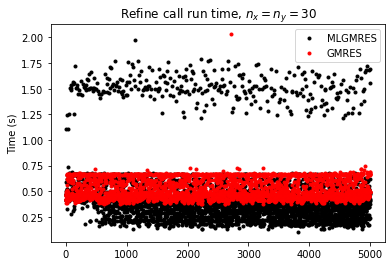

In [10]:
pp.plot(run_timeP2_ML_list,'.k',label='MLGMRES')
pp.plot(GmresRunTimeOriginal2,'.r',label='GMRES')
pp.title('Refine call run time, $n_x=n_y=30$')
pp.ylabel('Time (s)')
pp.legend(loc='best')
pp.savefig('EntireTime1.svg')

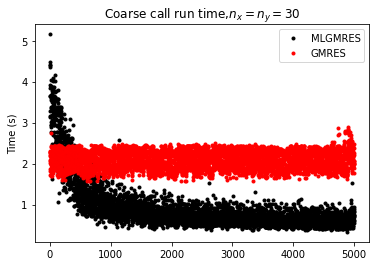

In [11]:
pp.plot(run_timeP1_ML_list,'.k',label='MLGMRES')
pp.plot(GmresRunTimeOriginal,'.r',label='GMRES')
pp.title('Coarse call run time,$n_x=n_y=30$')
pp.ylabel('Time (s)')
pp.legend(loc='best')
pp.savefig('EntireTime2.svg')

/home/kl748/Research/NERSC/GMRES-Learning/src_dir/util.py:68: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(a[-Window-1:-1])/Window


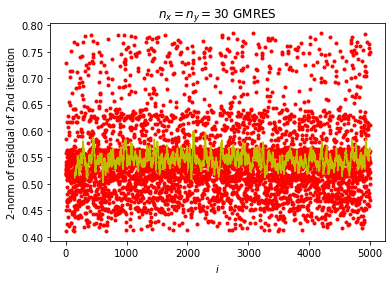

In [12]:
AVG=np.zeros((n_steps,1))
Err_Array=np.asarray(NonML_Err_List)
count=np.arange(0,n_steps)

for j in range(0,n_steps):
    AVG[j]=moving_average(np.asarray(Err_Array[:j]),j)

    
    
pp.plot(count,np.asarray(NonML_Err_List),'.r',count[150:-1],AVG[150:-1],'y')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 2nd iteration')
pp.title('$n_x=n_y=30$ GMRES')
pp.savefig('GMRES.svg')

/home/kl748/Research/NERSC/GMRES-Learning/src_dir/util.py:68: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(a[-Window-1:-1])/Window


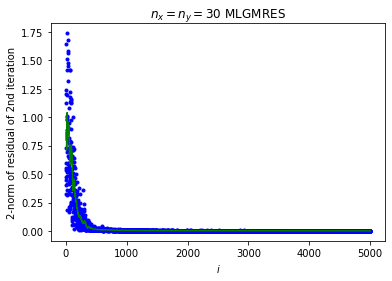

In [13]:
Err_Array_ML=np.asarray(Err_list)
AVGML=np.zeros((n_steps,1))

for j in range(0,n_steps):
    AVGML[j]=moving_average(np.asarray(Err_Array_ML[:j]),j)

pp.plot(count,np.asarray(Err_Array_ML),'.b',count[10:-1],AVGML[10:-1],'g')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 2nd iteration')
pp.title('$n_x=n_y=30$ MLGMRES')
pp.savefig('MLGMRES.svg')

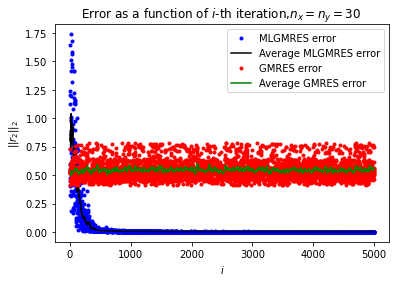

In [14]:
pp.plot(count,Err_Array_ML,'.b',label='MLGMRES error')
pp.plot(count[10:-1],AVGML[10:-1],'k',label='Average MLGMRES error')
pp.plot(count,Err_Array,'.r',label='GMRES error')
pp.plot(count[10:-1],AVG[10:-1],'g',label='Average GMRES error')

pp.xlabel('$i$')
pp.ylabel('$||r_2||_2$')
pp.title('Error as a function of $i$-th iteration,$n_x=n_y=30$ ')
pp.legend(loc='best')
pp.savefig('Compare.svg')

/home/kl748/Research/NERSC/GMRES-Learning/src_dir/util.py:68: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(a[-Window-1:-1])/Window


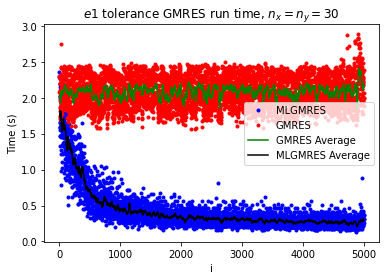

In [38]:
GmresRunTimeOriginal_AVG=np.zeros((n_steps,1))
ML_GMRES_Time_AVG=np.zeros((n_steps,1))


for j in range(0,n_steps):
    GmresRunTimeOriginal_AVG[j]=moving_average(np.asarray(GmresRunTimeOriginal[:j]),j)

for j in range(0,n_steps):
    ML_GMRES_Time_AVG[j]=moving_average(np.asarray(ML_GMRES_Time_list[:j]),j)
    
    
pp.plot(ML_GMRES_Time_list,'.b',label='MLGMRES')
pp.plot(GmresRunTimeOriginal,'.r', label='GMRES')
pp.plot(count[10:-1],GmresRunTimeOriginal_AVG[10:-1],'g', label='GMRES Average')
pp.plot(count[10:-1],ML_GMRES_Time_AVG[10:-1],'k', label='MLGMRES Average')

pp.ylabel('Time (s)')
pp.xlabel('i')
pp.title('$e1$ tolerance GMRES run time, $n_x=n_y=30$')
pp.legend(loc='best')
pp.savefig('Runtime1.svg')

/home/kl748/Research/NERSC/GMRES-Learning/src_dir/util.py:68: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(a[-Window-1:-1])/Window


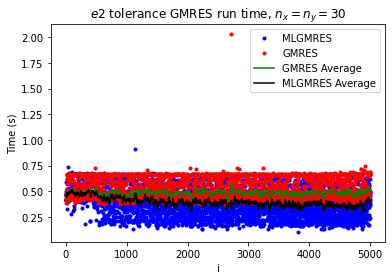

In [39]:
GmresRunTimeOriginal2_AVG=np.zeros((n_steps,1))
ML_GMRES_Time2_AVG=np.zeros((n_steps,1))
count=np.arange(0,n_steps)


for j in range(0,n_steps):
    GmresRunTimeOriginal2_AVG[j]=moving_average(np.asarray(GmresRunTimeOriginal2[:j]),j)

for j in range(0,n_steps):
    ML_GMRES_Time2_AVG[j]=moving_average(np.asarray(ML_GMRES_Time_list2[:j]),j)
    
    
pp.plot(ML_GMRES_Time_list2,'.b',label='MLGMRES')
pp.plot(GmresRunTimeOriginal2,'.r', label='GMRES')
pp.plot(count[10:-1],GmresRunTimeOriginal2_AVG[10:-1],'g', label='GMRES Average')
pp.plot(count[10:-1],ML_GMRES_Time2_AVG[10:-1],'k', label='MLGMRES Average')

pp.ylabel('Time (s)')
pp.xlabel('i')
pp.title('$e2$ tolerance GMRES run time, $n_x=n_y=30$')
pp.legend(loc='best')
pp.savefig('Runtime2.svg')

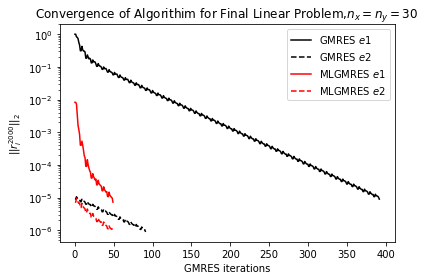

In [17]:
ML_Err=resid(A, Out, b/b_norm)
ML_Err2=resid(A, Out2, b/b_norm)



NonML_Err=resid(A, NonML_Out1, b/b_norm)
NonML_Err2=resid(A, NonML_Out2, b/b_norm)

pp.semilogy(NonML_Err,'k',label='GMRES $e1$')
pp.semilogy(NonML_Err2,'--k',label='GMRES $e2$')
pp.semilogy(ML_Err,'r',label='MLGMRES $e1$')
pp.semilogy(ML_Err2,'--r',label='MLGMRES $e2$')
pp.legend(loc='best')
pp.xlabel('GMRES iterations')
pp.ylabel('$||r^{2000}_{i}||_2$')
pp.title('Convergence of Algorithim for Final Linear Problem,$n_x=n_y=30$')
pp.savefig('Error.svg')

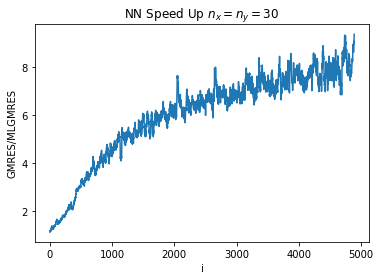

In [55]:
GMRESAVG=GmresRunTimeOriginal_AVG[10:-100]
MLGMRESAVG=ML_GMRES_Time_AVG[10:-100]
Ratio=np.divide(GMRESAVG,MLGMRESAVG)



pp.plot(Ratio)
pp.xlabel('i')
pp.ylabel('GMRES/MLGMRES')
pp.title("NN Speed Up $n_x=n_y=30$ ")
pp.savefig('SpeedUp.svg')

Text(0.5, 1.0, 'Error Ratio $n_x=n_y=30$ ')

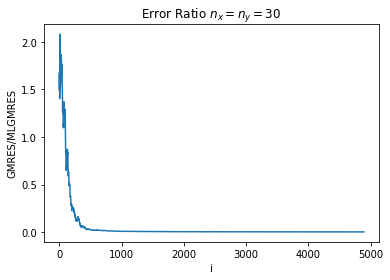

In [54]:
MLError_AVG=AVGML[10:-100]
Error_AVG=AVG[10:-100]
Ratio=np.divide(MLError_AVG,Error_AVG)



pp.plot(Ratio)
pp.xlabel('i')
pp.ylabel('GMRES/MLGMRES')
pp.title("Error Ratio $n_x=n_y=30$ ")

In [57]:
Err_Array=np.expand_dims(np.asarray(NonML_Err_List),axis=1)
Err_Array_ML=np.expand_dims(np.asarray(Err_list),axis=1)
GmresTime1Arr=np.expand_dims(np.asarray(GmresRunTimeOriginal),axis=1)
MLGmresTime1Arr=np.expand_dims(np.asarray(ML_GMRES_Time_list),axis=1)
GmresTime2Arr=np.expand_dims(np.asarray(GmresRunTimeOriginal2),axis=1)
MLGmresTime2Arr=np.expand_dims(np.asarray(ML_GMRES_Time_list2),axis=1)

WriteDataArr=np.concatenate((Err_Array_ML,Err_Array,GmresTime1Arr,MLGmresTime1Arr,GmresTime2Arr,MLGmresTime2Arr),axis=1)
np.savetxt('PerformanceData.txt',WriteDataArr)